---
---
# Análise exploratória e análise de correlação

---
---
## SME0878 Mineração Estatística de Dados - 1/2024
### Cícero Coimbra Fonseca - 12624912
### Gabriel Almeida Ferreira  - 12693924
### Helber Martins de Moraes - 10260181
---

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from sklearn.utils import resample
import seaborn as sns

np.random.seed(12624912)

In [ ]:
from IPython.display import HTML

def side_by_side(*dfs):
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 2em">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

## 1. Introdução
O GAPSI (Grupo de Apoio Psicopedagógico) da Universidade de São Paulo (USP) é um serviço destinado a oferecer suporte psicopedagógico aos estudantes em necessidade. Para esse fim, o grupo (junto do Apoia USP) oferece diversos caminhos de apoio para estudantes que o precisam, organizando ações preventivas e protetivas à saúde mental pelo ICMC. Dessa forma, é necessário conhecer as causas ou no mínimo os indicadores de um estudante que precisa desse apoio, no sentido de oferecer ajuda aos que mais tem chance de precisar, juntamente de tentar entender as maiores necessidades da comunidade como um todo.

Para esse fim, o grupo faz um forumlário anual, o qual iremos analisar com o objetivo de prever, mais especificamente, casos de transtornos mentais comuns a partir das respostas do questionário. Particularmente, trabalharemos com dados de $362$ estudantes, em que para cada um temos $23$ atributos. Como o formulário é de caráter voluntário, não é certo que podemos tratar as respostas como uma amostra aleatória dos estudantes, e dessa forma qualquer interpretação causal simples é dúbia.

Algumas das respostas são exibidas abaixo.




In [ ]:
!gdown 1ArogXcEX4g-oRH0A8k_uM_WCs87fWAnW


Downloading...
From: https://drive.google.com/uc?id=1ArogXcEX4g-oRH0A8k_uM_WCs87fWAnW
To: /content/Grad2023ID.xlsx
100% 58.4k/58.4k [00:00<00:00, 54.3MB/s]


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
file_path = '/content/Grad2023ID.xlsx'
df = pd.read_excel(file_path)
df.head()

ID      Q02               Q03             Q04                 Q05  \
0     1   Até 19   Homem cisgênero  Preta ou parda       Heterossexual   
1     2  20 a 25  Mulher cisgênero          Branca           Bissexual   
2     3   Até 19  Mulher cisgênero          Branca       Heterossexual   
3     4  20 a 25  Mulher cisgênero          Branca           Bissexual   
4     5  20 a 25  Mulher cisgênero  Preta ou parda  Outras Orientações   

      Q06 moradia       Q09                                   Q10   Q11  ...  \
0   234.0     Não      EESC                      Engenharia Civil  2023  ...   
1   110.0     Não  Eng Comp              Engenharia de Computação  2021  ...   
2  1415.0     Não      EESC                   Engenharia Mecânica  2023  ...   
3   800.0     Não      ICMC  Sistemas de Informação - Bacharelado  2023  ...   
4    55.0     Não      IQSC                 Química - Bacharelado  2022  ...   

  Q20  Q21 score_PercepDif nivelSRQ  scoreSRQ scoreDifAcad  scoreRC scorePTC  \
0   5  Não        1.833333  Nível 0         2     4.333333      3.2      2.0   
1   5  Sim        2.833333  Nível 1         9     2.166667      2.6      0.8   
2   5  Sim        2.166667  Nível 1         9     2.500000      3.4      1.6   
3   5  Sim        3.500000  Nível 1        13     1.333333      2.8      0.6   
4   3  Sim        3.833333  Nível 1        13     3.666667      1.8      1.6   

   scoreQ52  scoreQ53  
0      3.50      3.50  
1      3.75      3.75  
2      2.50      3.25  
3      3.25      3.25  
4      3.00      2.25  

[5 rows x 24 columns]

Com esses dados em mente, diversos métodos para a tarefa ficam evidentes. As metodologias mais ortodoxas, que planejamos explorar, ficariam na utilização de métodos de regressão (ou árvores, ou uma floresta aleatória). Em particular, dado que a resposta é um escore que vai de $1$ a $20$ (ou, idênticamente, uma categoria de $1-3$ ordenada), é importante que a regressão respeite tanto o suporte da resposta (números inteiros $1-20$) quanto a ordenação (de menos a mais severo); dessa forma, um modelo multinomial logito ordinal (veja o capítulo 13 de [1])  , por exemplo, talvez seja apropriado.

Pode ser interessante analisar o efeito da suposição da ordenação, usando, por exemplo, um modelo multinomial logito mais simples. Também, por óbvio, é interessante modificar a função de ligação nesse caso. Outra estratégia seria em re-escalar a resposta e usar uma regresão beta, tratando-a como contínua.

Notemos, também, que temos diversas covariáveis categóricas, mas algumas quantitativas (em particular, a distância da moradia), das quais não é de se esperar uma relação linear ou simples; é possível que, nesses casos, seja necessária a utilização de componentes não-paramétricos (por exemplo, usando GAMLSS , como descrito em [2] ou no capítulo 2 de [1]).

Finalmente, como nosso objetivo é preditivo e não explicativo, planejamos comparar ao final os modelos tanto fazendo uso de critérios de informação quanto estatísticas tomadas a partir da base de teste, por exemplo, construindo uma matriz de confusão para os níveis de severidade de cada modelo e comparando as taxas de erro, digamos, de quantos estudantes são classificados errôneamente como de baixa severidade e vice versa.

Dependendo da qualidade desses modelos e dos dados na predição, talvez seja possível a construção de um modelo mais explicativo construíndo uma variável latente para o risco, usando, por exemplo, um modelo de análise de caminhos; entretanto, a possibilidade ou impossibilidade de concluir essa tarefa depende fortemente da relação dos dados com a resposta e se é possível construir uma estrutura razoável para os dados tal que a variável latente faça sentido.

## 2. Estudo dos dados

Para esses dados, é bastante importante considerar o dicionário que o acompanha, para entender qual o significado de cada variável quando necessário, portanto carreagaremos este arquivo também.

In [ ]:
planilhas = pd.read_excel('/content/Grad2023ID.xlsx', sheet_name = [0,1])
df , dicionario = planilhas[0] , planilhas[1]
dicionario.columns = ['Questão', 'Conteúdo', 'Tipo do atributo', 'Valores']

Agora, iniciamos com alguma limpeza de dados. Como é de praxe, verifiquemos se há dados faltantes:

In [ ]:
print(f"""Colunas com valores faltantes/número:
      {df.isnull().sum()[df.isnull().sum() > 0]}""")

Colunas com valores faltantes/número:
      Q13    14
dtype: int64


Há valores faltantes apenas na questão, uma variável categórica indicando a experiência profissional do estudante. No dicionário de dados, temos as categorias
- Sim, formal (com registro ou contrato)
- Sim, informalmente
- Não, mas já tive emprego (formal ou informalmente) e tenho experiência profissional
- Não e nunca tive emprego
- Outro

Já, nos dados, observamos as categorias

In [ ]:
df['Q13'].unique()

array(['Não, mas já tive emprego (formal ou informalmente) e tenho experiência profissional',
       'Sim, informalmente', 'Não e nunca tive emprego', nan,
       'Sim, formal (com registro ou contrato)'], dtype=object)

Dessa forma, podemos inferir que os dados faltantes correspondem à categoria "Outros", mas há alguma dúvida; não podemos ter certeza se esse valor nulo não é, na verdade, uma mistura de respostas "outros" com valores faltantes com algum mecanismo relevante, mas mesmo se esse for o caso, o número pequeno de respostas com essa característica nos permite certa falta de preocupação nesse sentido.



In [ ]:
print(f"Se os dados fossem balanceados, haveria {len(df)/20} observações para cada nível de ScoreSQR.")


Se os dados fossem balanceados, haveria 18.1 observações para cada nível de ScoreSQR.


In [ ]:
df['scoreSRQ'].value_counts()


scoreSRQ
8     34
14    31
10    26
11    24
6     24
13    21
12    21
3     21
9     21
7     19
4     16
15    14
2     14
5     13
16    12
1     10
18     9
17     9
0      9
19     8
20     6
Name: count, dtype: int64


Também é de praxe analisar o balanceamento dos dados. Queremos prever o "scoreSRQ", correspondendo ao escore de risco de transtornos mentais, que é representado por um inteiro em 20 níveis ordenados (no sentido negativo). Isso é :  um SQR muito alto indica que o indivíduo tem propensão a desenvolver algum tipo de transtorno mental. Ao observar as tabelas acima, nota-se que os dados não estão desbalanceados, tendo em vista que há  poucas observações para valores extremos e um grande número de observações para valores intermediários. Esse desbalanceamento deve ser considerado na análise de dados, principalmente ao selecionar um ponto de corte e/ou ao tirar conclusões sobre indivíduos nos níveis mais extremos de SQR, principalmente aqueles com SQR 17, 19 e 20, que têm menos de 9 observações e correspondem a indivíduos com uma grande propensão a ter doenças mentais

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362 entries, 0 to 361
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0     ID             362 non-null    int64  
 1   Q02              362 non-null    object 
 2   Q03              362 non-null    object 
 3   Q04              362 non-null    object 
 4   Q05              362 non-null    object 
 5   Q06              362 non-null    float64
 6   moradia          362 non-null    object 
 7   Q09              362 non-null    object 
 8   Q10              362 non-null    object 
 9   Q11              362 non-null    object 
 10  Q13              348 non-null    object 
 11  Q15              362 non-null    object 
 12  Q17              362 non-null    object 
 13  Q19              362 non-null    object 
 14  Q20              362 non-null    int64  
 15  Q21              362 non-null    object 
 16  score_PercepDif  362 non-null    float64
 17  nivelSRQ        

Existem algumas poucas variáveis numéricas originalmente no conjunto de dados, discriminadas por "int64" ou "float64". As demais variáveis identificadas por object são uma representação de tipo mais genérica do pandas, normalmente strings.

In [ ]:
df.duplicated().sum()

0

Não existem dados duplicados.

De maneira geral, o conjunto de dados está bem organizado e conta com um dicionário de atributos bem redigido, o que provavelmente se deve ao ótimo planejamento para sua coleta. Apenas um dos atributos possui valores ausentes.

#### Algumas considerações sobre o processamento de dados para aplicações posteriores:

* Alguns atributos são ordinais e já estão codificados em suas respectivas escalas. Sempre que possível, é ideal manter essa escala original (facilita futuras interpretações). Em hipótese alguma devemos fazer uma transformação que altere a ordem das observações, segundo essa escala.

* Atributos categóricos podem ser transformados através do One-Hot Encoding. Se um modelo de regressão  for utilizado, é útil codificar em k - 1 categorias, deixando uma categoria como categoria de referência

* O atributo "Q06" pode ser utilizado para criar uma nova categoria de "residente de São Carlos".

## 3. Análise Exploratória

### 3.1 Visualização dos dados

Vejamos como estão distribuídas as observações em cada variável do conjunto de dados. Cada tipo de variável têm visualizações específicas adequadas.

#### 3.1.1 Atributos categóricos

Os gráficos de barras são bastante úteis para mostrar comparações entre quantidades em diferentes categorias. Por meio de um loop, é possível gerar de uma só vez todas as visualizações para as variáveis de interesse:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

def get_bar_plot(variavel):

  sns.countplot(data = df, x = variavel, stat = 'percent')
  plt.show()

In [ ]:
dicionario.loc[dicionario['Tipo do atributo'] == 'Categórica','Questão']

0          Q02
1          Q03
2          Q04
3          Q05
5      Moradia
6          Q09
7          Q10
8          Q11
9          Q13
10         Q15
11         Q17
12         Q19
14         Q21
16    nivelSRQ
Name: Questão, dtype: object

In [ ]:
categoricas = ['Q02', 'Q03', 'Q04', 'Q05', 'moradia','Q09',
       'Q11', 'Q15', 'Q17', 'Q19','Q21','nivelSRQ']

Nesse caso, no eixo x temos os níveis da categoria e no eixo y a porcentagem das observações de cada nível (em relação a todas as observações).

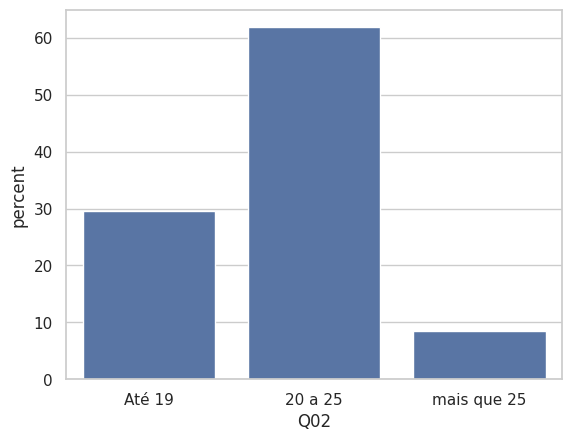

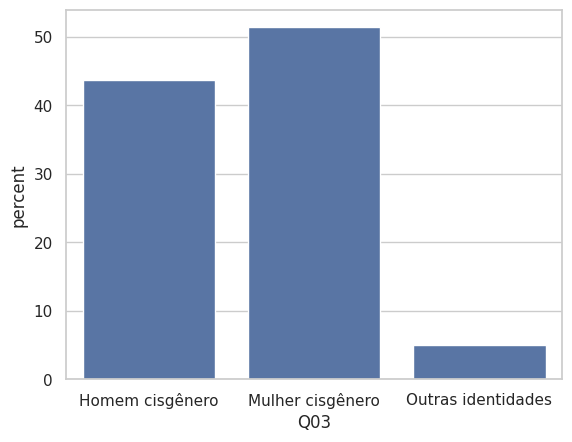

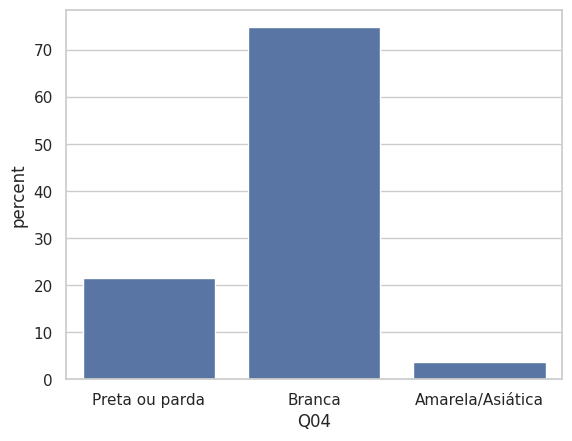

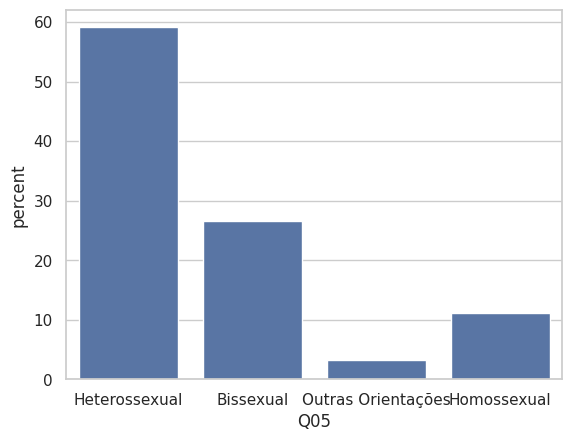

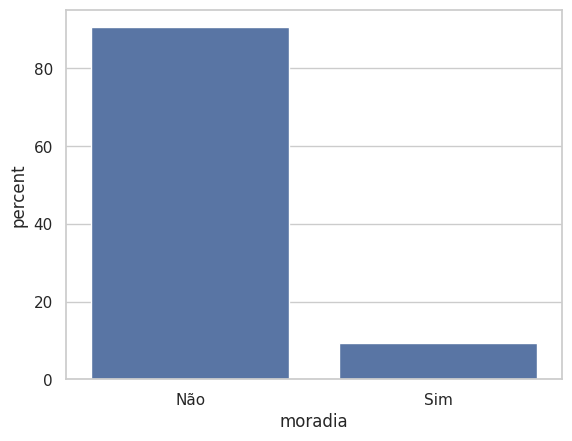

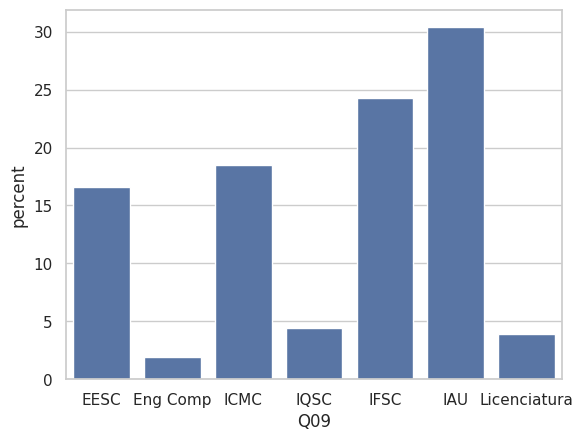

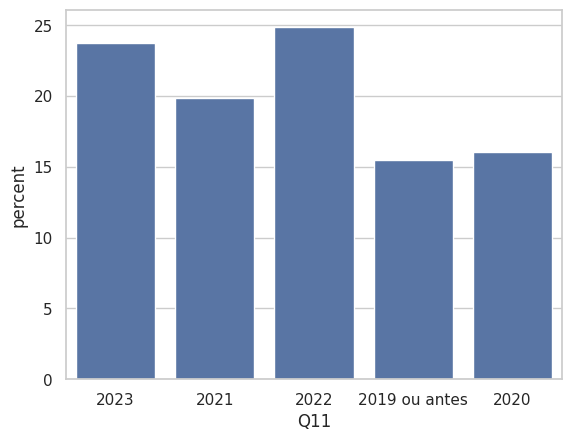

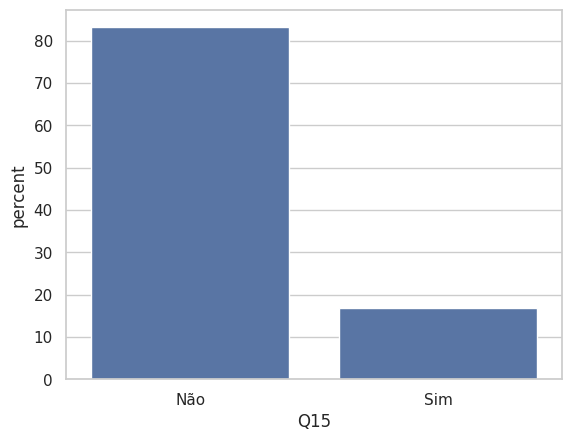

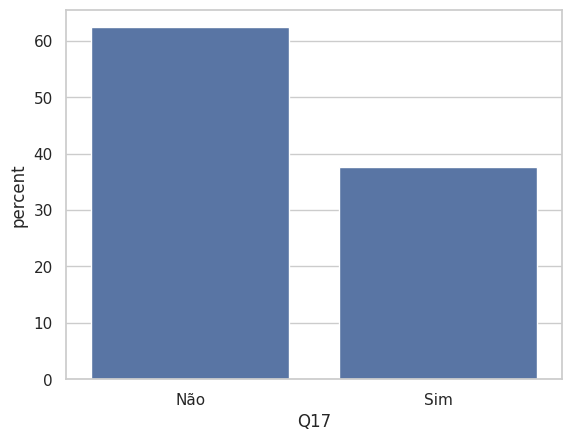

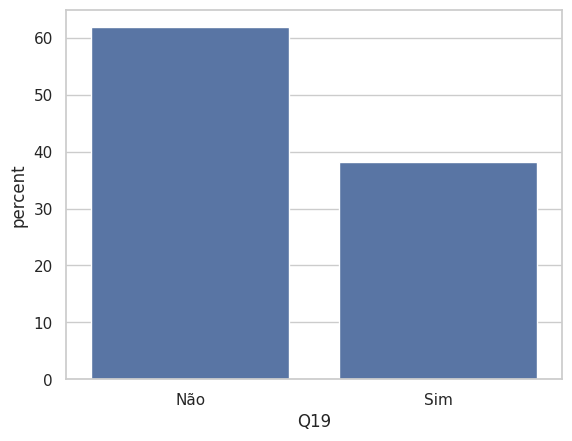

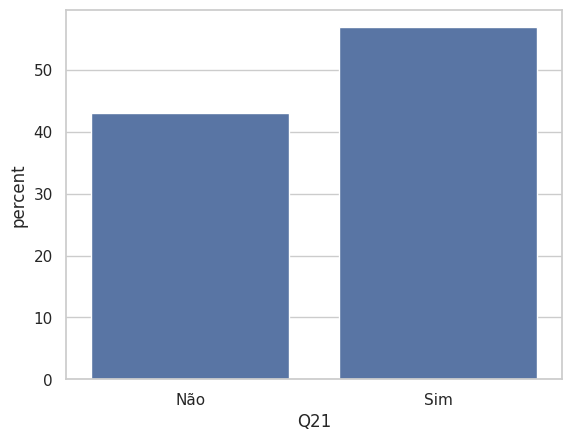

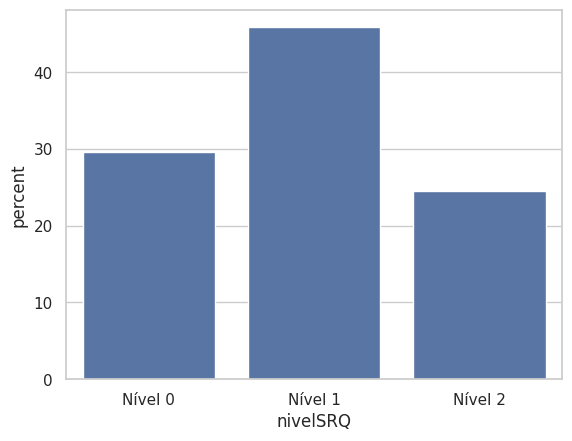

In [ ]:
for i in categoricas:
  get_bar_plot(i)

Esses gráficos podem ser utilizados para caracterizar aqueles que responderam ao questionário. Por exemplo, em relação aos outros institutos, há poucos alunos do eng comp e da licenciatura, além disso mais  de 80% daqueles que responderam ao questionário não possuem diagnósticos em saúde física

Atributos com nomes muito grandes ou muitos níveis são melhor apresentados em formato de tabelas, como no caso do curso do estudante:

In [ ]:
df['Q10'].value_counts()

Q10
Arquitetura e Urbanismo                                      110
Física - Bacharelado                                          30
Física Computacional                                          29
Engenharia Ambiental                                          28
Ciências Físicas e Biomoleculares - Bacharelado               25
Ciências da Computação - Bacharelado                          22
Ciências Exatas - Licenciatura                                18
Química - Bacharelado                                         16
Estatística e Ciência de Dados                                14
Sistemas de Informação - Bacharelado                          12
Engenharia de Computação                                      10
Engenharia Civil                                              10
Matemática - Bacharelado                                       9
Engenharia Mecânica                                            6
Engenharia Mecatrônica                                         5
Matemática Aplicada e

#### 3.1.2 Atributos numéricos

A variável Q06, que representa a distância do local de procedência do estudante em relação a São Carlos, é numérica e contínua, logo é possível verificar a forma da distribuição da amostra desenhando uma linha sobre o histograma com o argumento "kde" da função histplot:

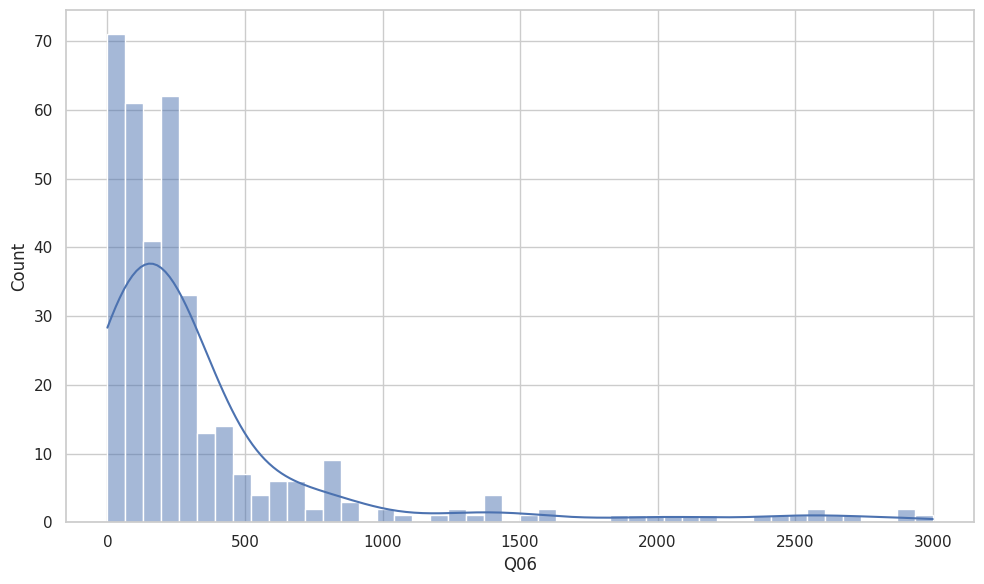

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data = df, x = 'Q06', fill = True, kde = 'True')
plt.tight_layout()

In [ ]:
df['Q06'].describe()

count     362.000000
mean      359.186188
std       535.682768
min         0.000000
25%       100.000000
50%       200.000000
75%       337.500000
max      3000.000000
Name: Q06, dtype: float64

A maioria dos alunos está em São Carlos, ou muito perto da região.

Pode ser útil definir um ponto de referência.
* Distância aproximada de São Carlos para São Paulo é 256 km (a mediana é de 200 km, indicando que a maioria mora mais perto do que a distância para São Paulo)
* Distância entre São Carlos - SP e Campinas · 141 km

A distância média é de aproximadamente 359 km, mas essa não é uma medida muito útil para análise, já que ela é muito afetada por outliers, que podem ser observados na longa cauda a direita da distribuição.

#### 3.1.3 Atributos ordinais (escalas)

Nas variáveis ordinais, utilizaremos os gráficos de barras, mas os boxplots também serão úteis para analisar como os dados estão distribuídos, já que se tratam de atributos numéricos.

Para esse fim, geramos diversos gráficos, dois para cada variável:

In [ ]:
from matplotlib.ticker import FormatStrFormatter

def get_bar_plot_escala(variavel, show_plot = True, rotate_xticklabels = False):
  if show_plot:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))
    sns.countplot(data = df, x = variavel, stat = 'percent',ax = ax1)
    ax1.set_title("Bar plot")
    if rotate_xticklabels:
      ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
      ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

    sns.boxplot(data = df, y = variavel,ax = ax2)
    ax2.set_title("Boxplot")
    fig.tight_layout()
    fig.show()

  resumo_df = df[variavel].agg(['mean', 'std',  # Media variancia
                                   'min',lambda x : x.quantile(0.25) , lambda x :  x.quantile(0.5) , lambda x : x.quantile(0.75)  ,'max', # Quantis
                                   'skew' , lambda x : x.kurtosis(), # assimetria , curtose
                                   lambda x : x.std()/x.mean(), lambda x :  x.quantile(0.75) -   x.quantile(0.25)]) # Cv, IQR


  resumo_df = pd.DataFrame(resumo_df)
  resumo_df.index = ['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis(Fisher)', 'CV', 'IQR']



  display(resumo_df.T)

mean       std  min  25%  50%   75%   max  skewness  \
scoreSRQ  9.502762  4.992653  0.0  6.0  9.5  13.0  20.0  0.044668   

          kurtosis(Fisher)       CV  IQR  
scoreSRQ         -0.775175  0.52539  7.0

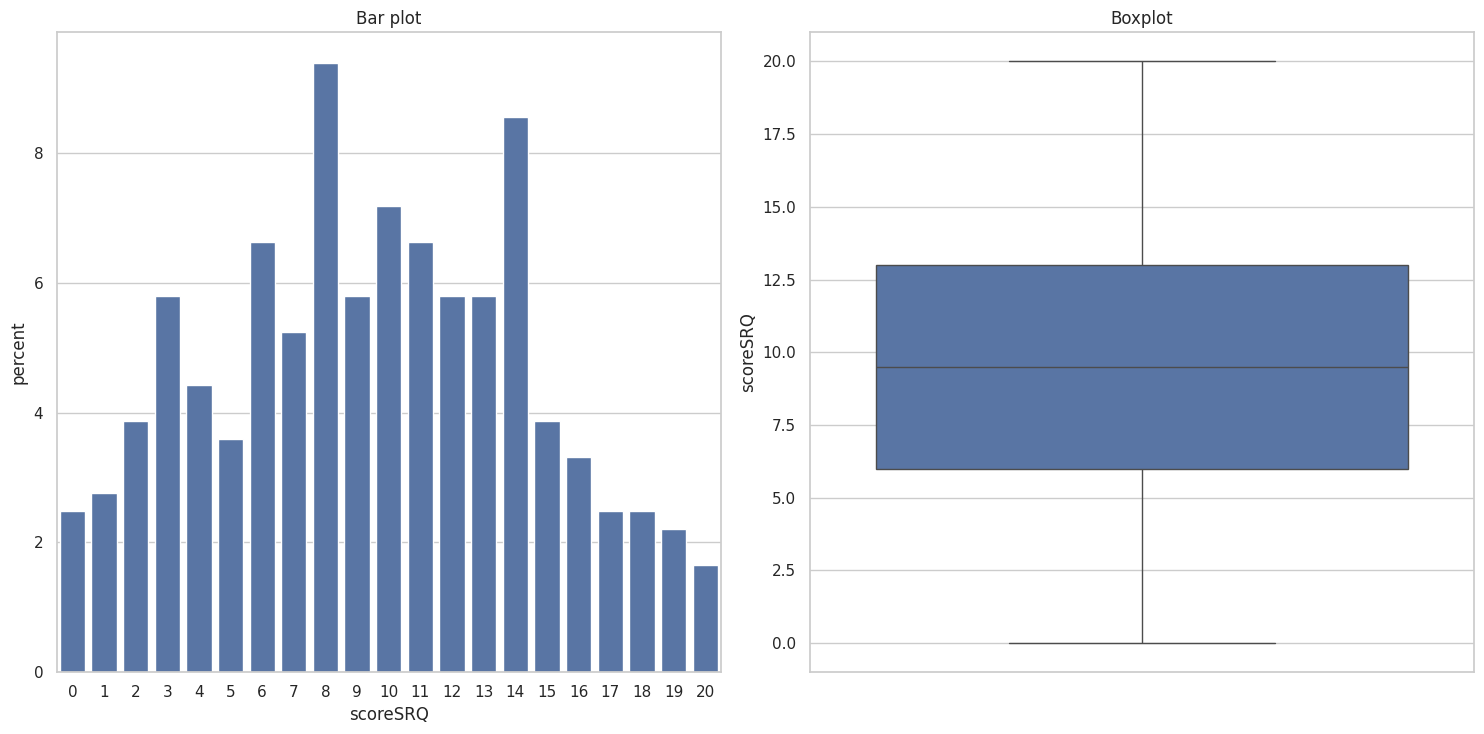

In [ ]:
get_bar_plot_escala('scoreSRQ')

O gráfico indica que a maior parte dos alunos enquadram-se nos score centrais referentes ao risco de desnvolvimento de transtorno mental.



<ipython-input-25-00e663a1d422>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


mean       std  min  25%       50%       75%       max  \
scoreDifAcad  3.082413  0.814255  1.0  2.5  3.166667  3.666667  4.833333   

              skewness  kurtosis(Fisher)        CV       IQR  
scoreDifAcad -0.220112         -0.448972  0.264162  1.166667

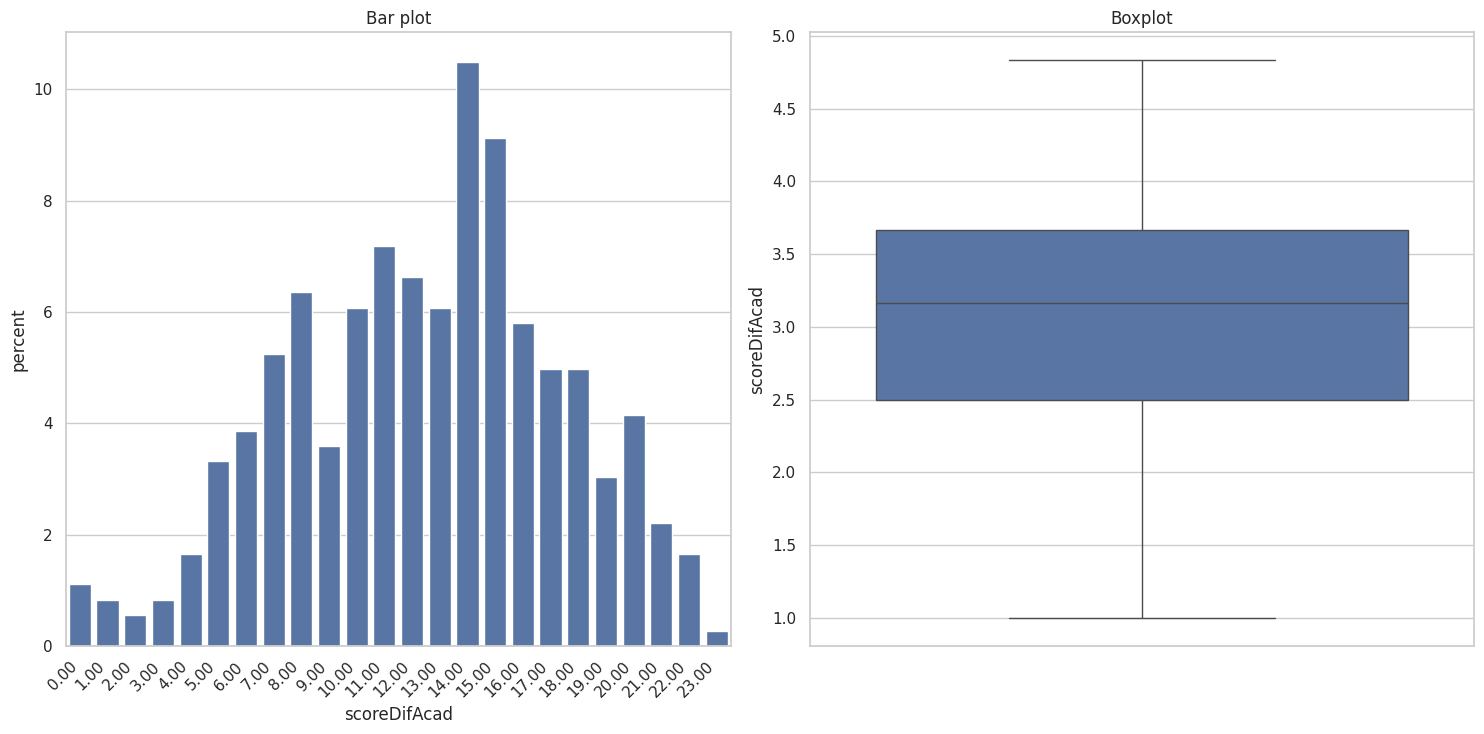

In [ ]:
get_bar_plot_escala('scoreDifAcad', rotate_xticklabels=True)

mean       std  min  25%  50%  75%  max  skewness  \
scoreRC  3.060221  0.832723  1.0  2.6  3.0  3.6  5.0  0.058196   

         kurtosis(Fisher)        CV  IQR  
scoreRC         -0.316309  0.272112  1.0

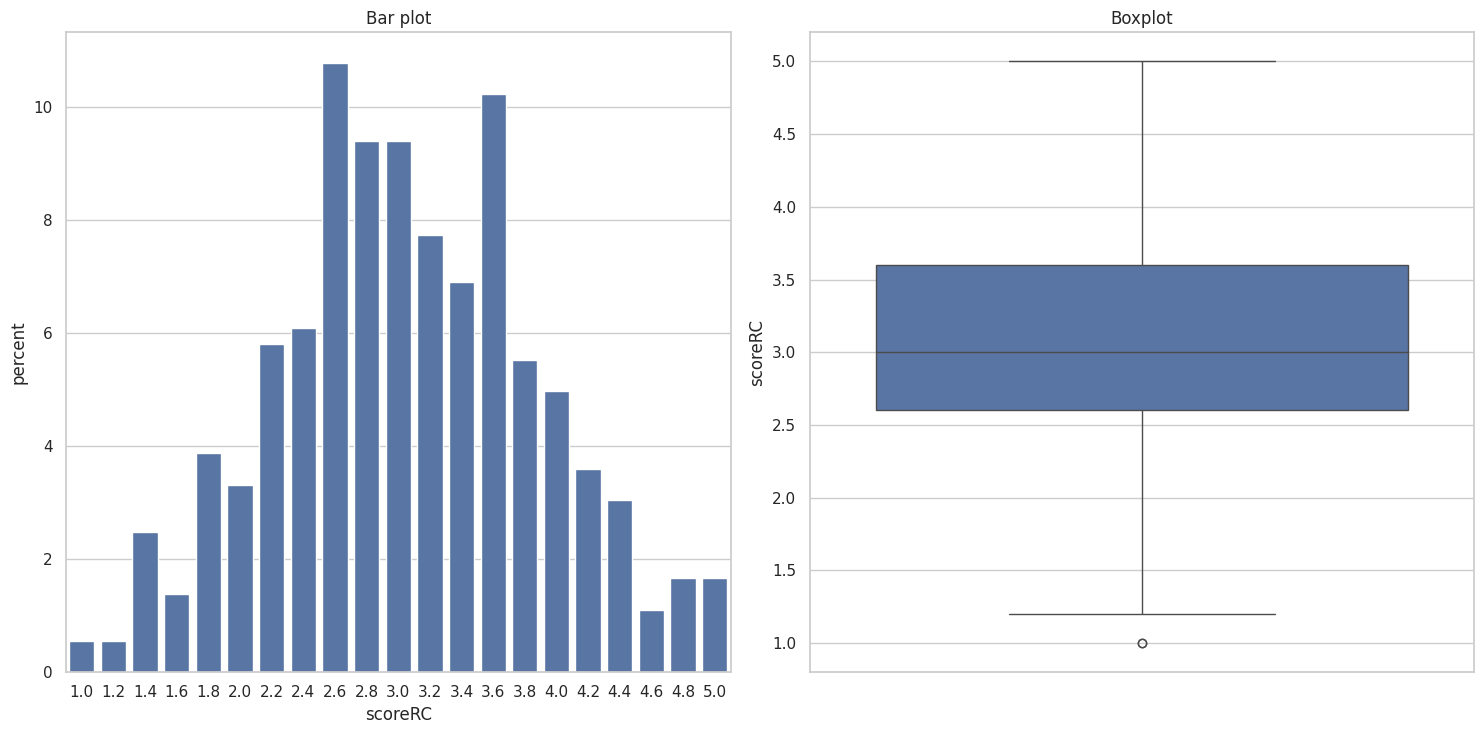

In [ ]:
get_bar_plot_escala('scoreRC')

Do mesmo modo que no caso do scoreSRQ, os scores sobre a percepção de dificuldade acadêmica e sobre relações e comunicação, também apresentam maior parte dos registros na região central.

mean       std  min  25%  50%  75%  max  skewness  \
scorePTC  1.337569  0.457831  0.4  1.0  1.4  1.6  2.0 -0.391139   

          kurtosis(Fisher)        CV  IQR  
scorePTC         -0.767963  0.342286  0.6

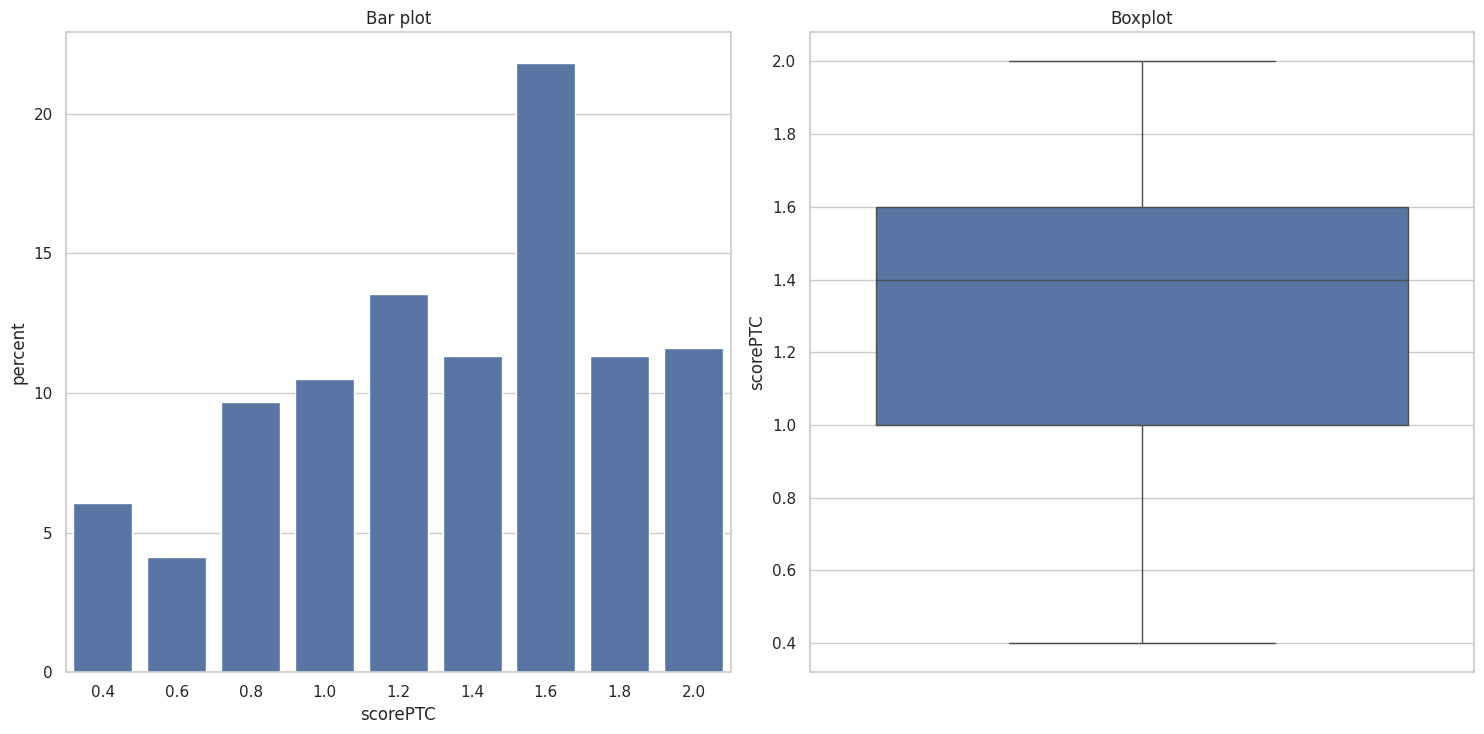

In [ ]:
get_bar_plot_escala('scorePTC')

mean       std  min     25%  50%  75%  max  skewness  \
scoreQ52  3.399171  1.020828  1.0  2.8125  3.5  4.0  5.0 -0.483978   

          kurtosis(Fisher)        CV     IQR  
scoreQ52         -0.248239  0.300317  1.1875

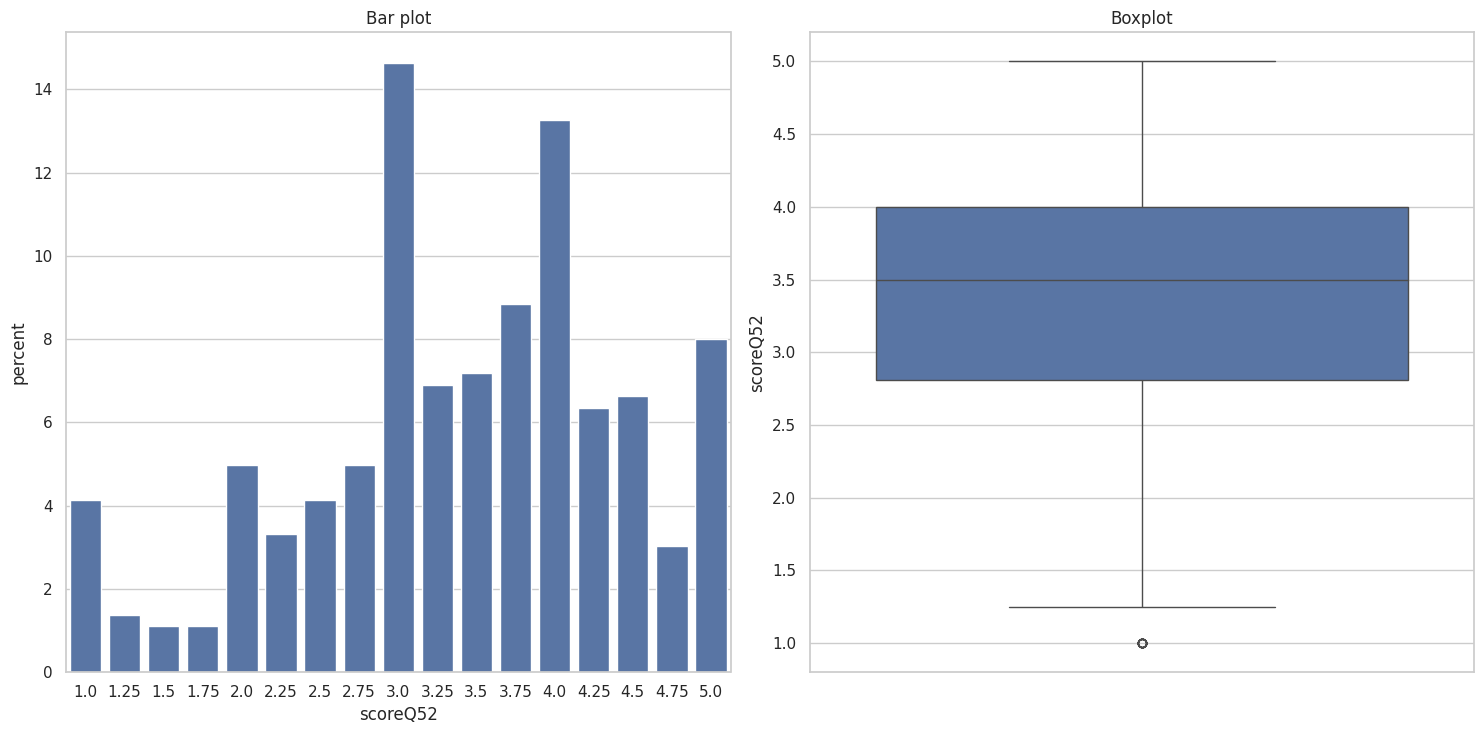

In [ ]:
get_bar_plot_escala('scoreQ52')

mean       std  min  25%  50%  75%  max  skewness  \
scoreQ53  2.865331  1.076534  1.0  2.0  3.0  3.5  5.0  0.003111   

          kurtosis(Fisher)       CV  IQR  
scoreQ53         -0.645924  0.37571  1.5

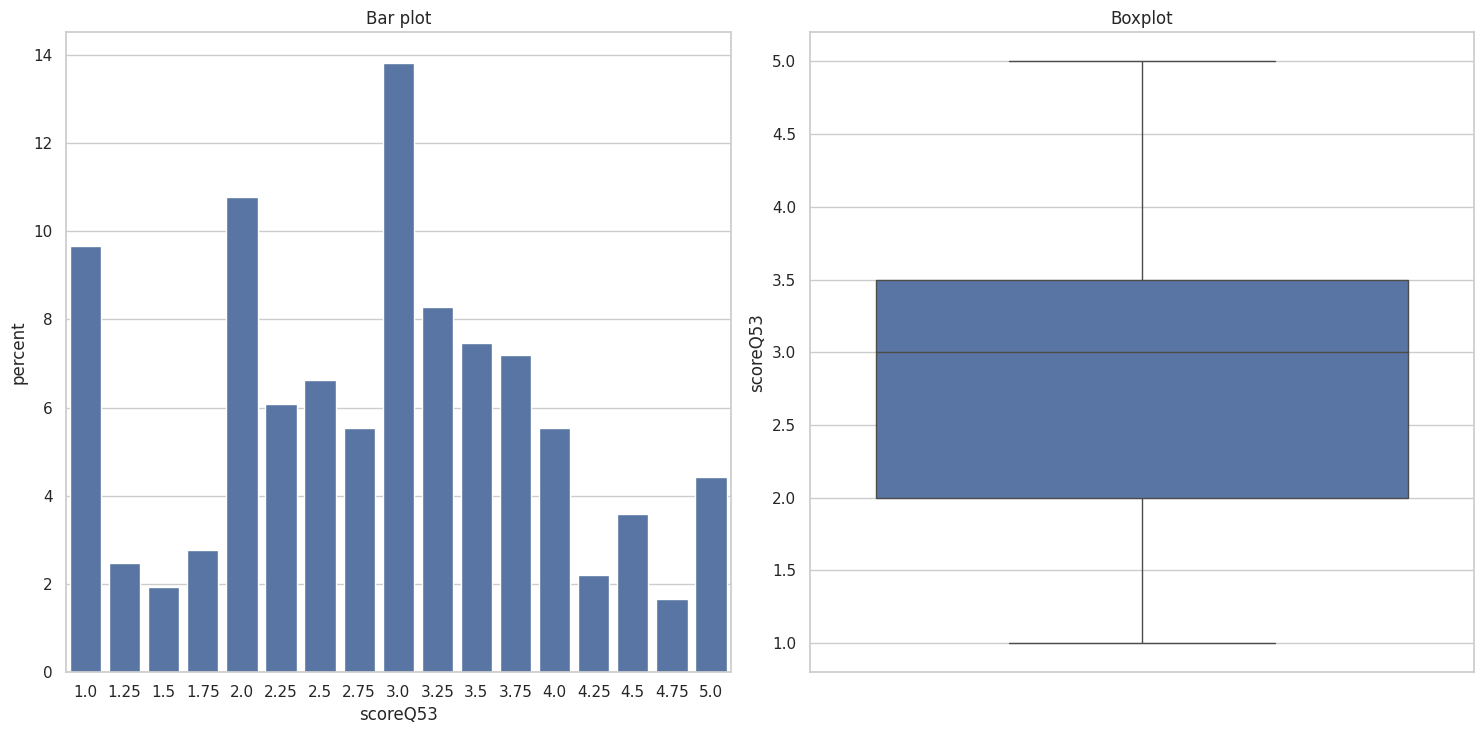

In [ ]:
get_bar_plot_escala('scoreQ53')

mean       std  min  25%  50%  75%  max  skewness  kurtosis(Fisher)  \
Q20  4.127072  1.042258  1.0  3.0  4.0  5.0  5.0 -1.112604          0.673874   

           CV  IQR  
Q20  0.252542  2.0

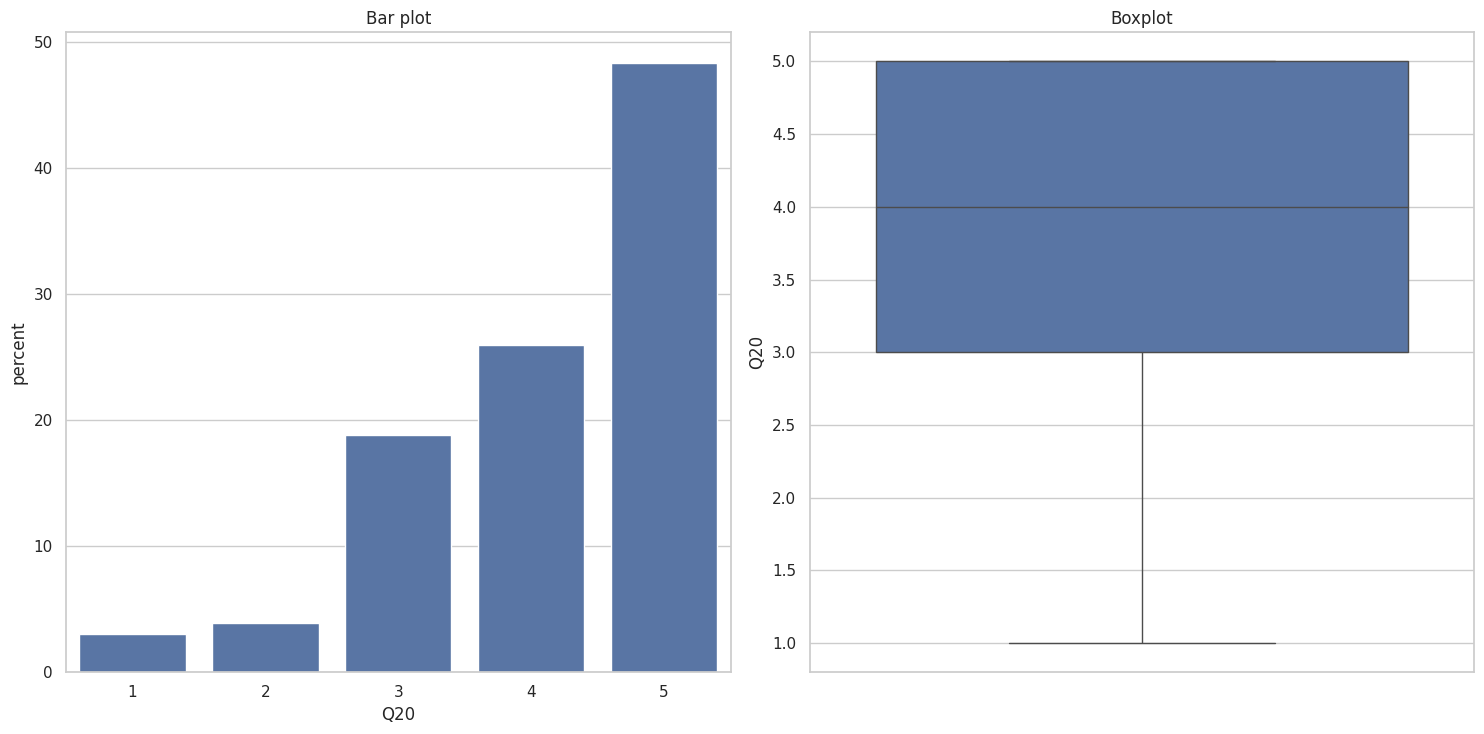

In [ ]:
get_bar_plot_escala('Q20')

Entre todas as variáveis analisadas nessa seção, a Q20, que representa as condições para permanência dos alunos, foi a única com comportamento estritamente crescente.

### 3.2 Associação

#### 3.2.1 Atributos ordinais (escala)



A correlação de Kendall é utilizada para quantificar a correlação monotônica entre duas variáveis. Essa estatística também pode ser utilizada em testes de independência e pode ser interpretada tanto em relação à magnitude (força da associação) quanto ao sinal (direção da associação).

In [ ]:
escala = ['Q20','score_PercepDif', 'scoreSRQ', 'scoreDifAcad', 'scoreRC', 'scorePTC','scoreQ52', 'scoreQ53']

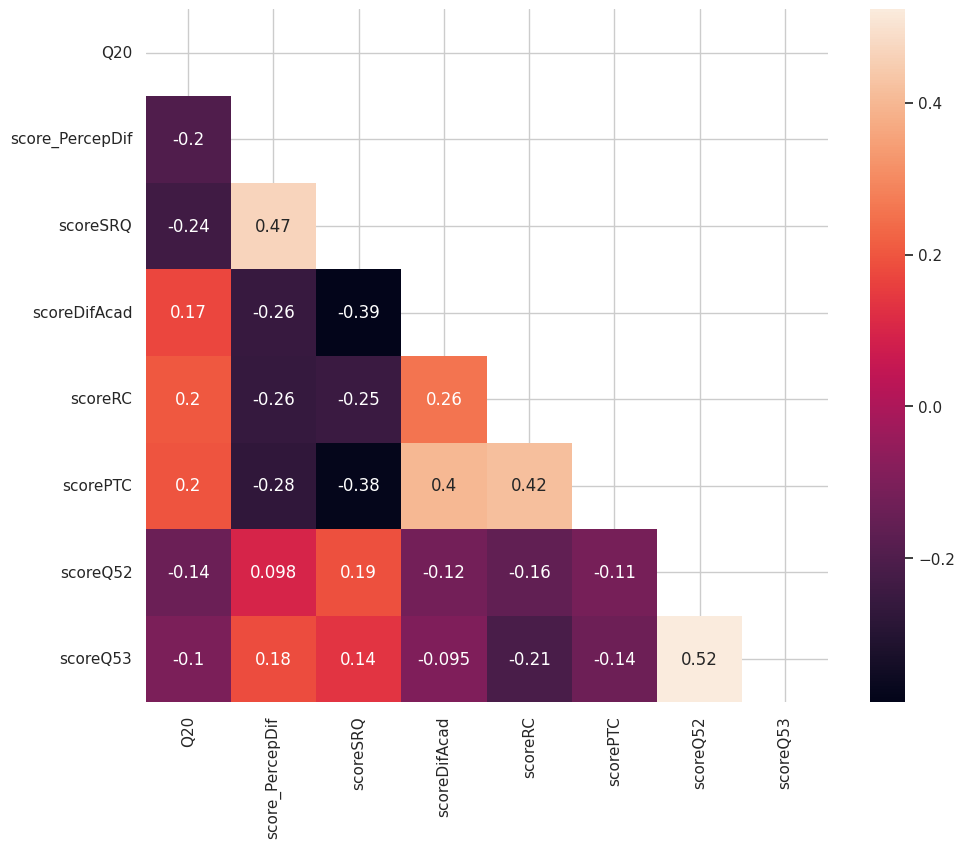

In [ ]:
corr_matrix = df.loc[:,escala].corr(method='kendall')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(11, 9))
sns.heatmap(corr_matrix, mask = mask, annot= True)
plt.show()

Dentre as variáveis ordinais, as mais correlacionadas são a scoreQ52 e scoreQ53, que representam, respectivamente, o score sobre discriminação da USP São Carlos e o score sobre discriminação da unidade de ensino, que podemos entender como variáveis parecidas. É a maior correlação moderada entre variáveis (0.52). Em seguida, aparece a correlação entre o scoreSRQ, que indica o risco do desenvolvimento de transtorno mental, com o scoreDifAcad, representando a percepção do aluno sobre dificuldades acadêmicas, apontando que existe associação entre as variáveis


Um gráfico de dispersão pode ser utilizado para visualizar entre os atributos estudados nessa seção. Para facilitar a visualização, uma reta de regressão é exibida. Esses gráficos também são úteis para detectar possíveis outliers, que são pontos que se destoam da nuvem de pontos. Por exemplo, no scatter plot entre scoreSRQ e score_PercepDif, percebe-se claramente uma associação positiva entre as variáveis, com um possível outlier no canto inferior direito. Enquanto no gráfico entre as variáveis scoreQ52 e score_PercepDif não é observada uma tendência tão expressiva na nuvem de pontos, o que também é refletido pelo baixo coeficiente de correlação

<Axes: xlabel='scoreSRQ', ylabel='score_PercepDif'>

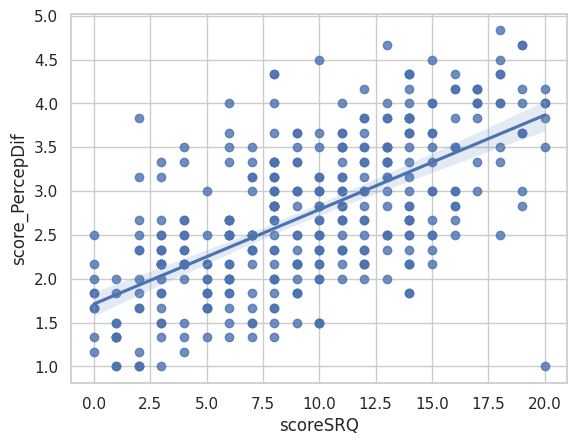

In [ ]:
sns.regplot(data=df, x="scoreSRQ", y="score_PercepDif")



<Axes: xlabel='scoreQ52', ylabel='score_PercepDif'>

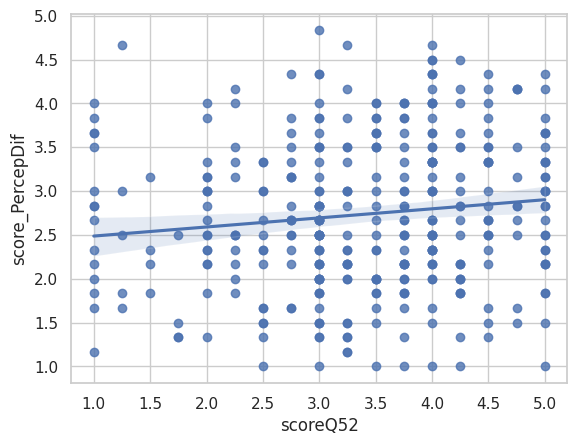

In [ ]:
sns.regplot(data=df, x="scoreQ52", y="score_PercepDif")


Uma matriz de gráficos de dispersão, entre os atributos do tipo escala, é apresentada. Nela, pode-se observar mais profundamente a relação entre os atributos. Uma escala foi utilizada para colorir os pontos de acordo com o nível da variável de interesse scoreSRQ

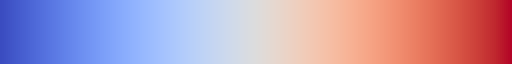

In [ ]:
# Escala de cores (podemos mudar, veja https://seaborn.pydata.org/generated/seaborn.color_palette.html)
sns.color_palette("coolwarm", as_cmap=True)
#Em que o azul indica pouca propensão para doenças mentais e o vermelho indica muita propensão.

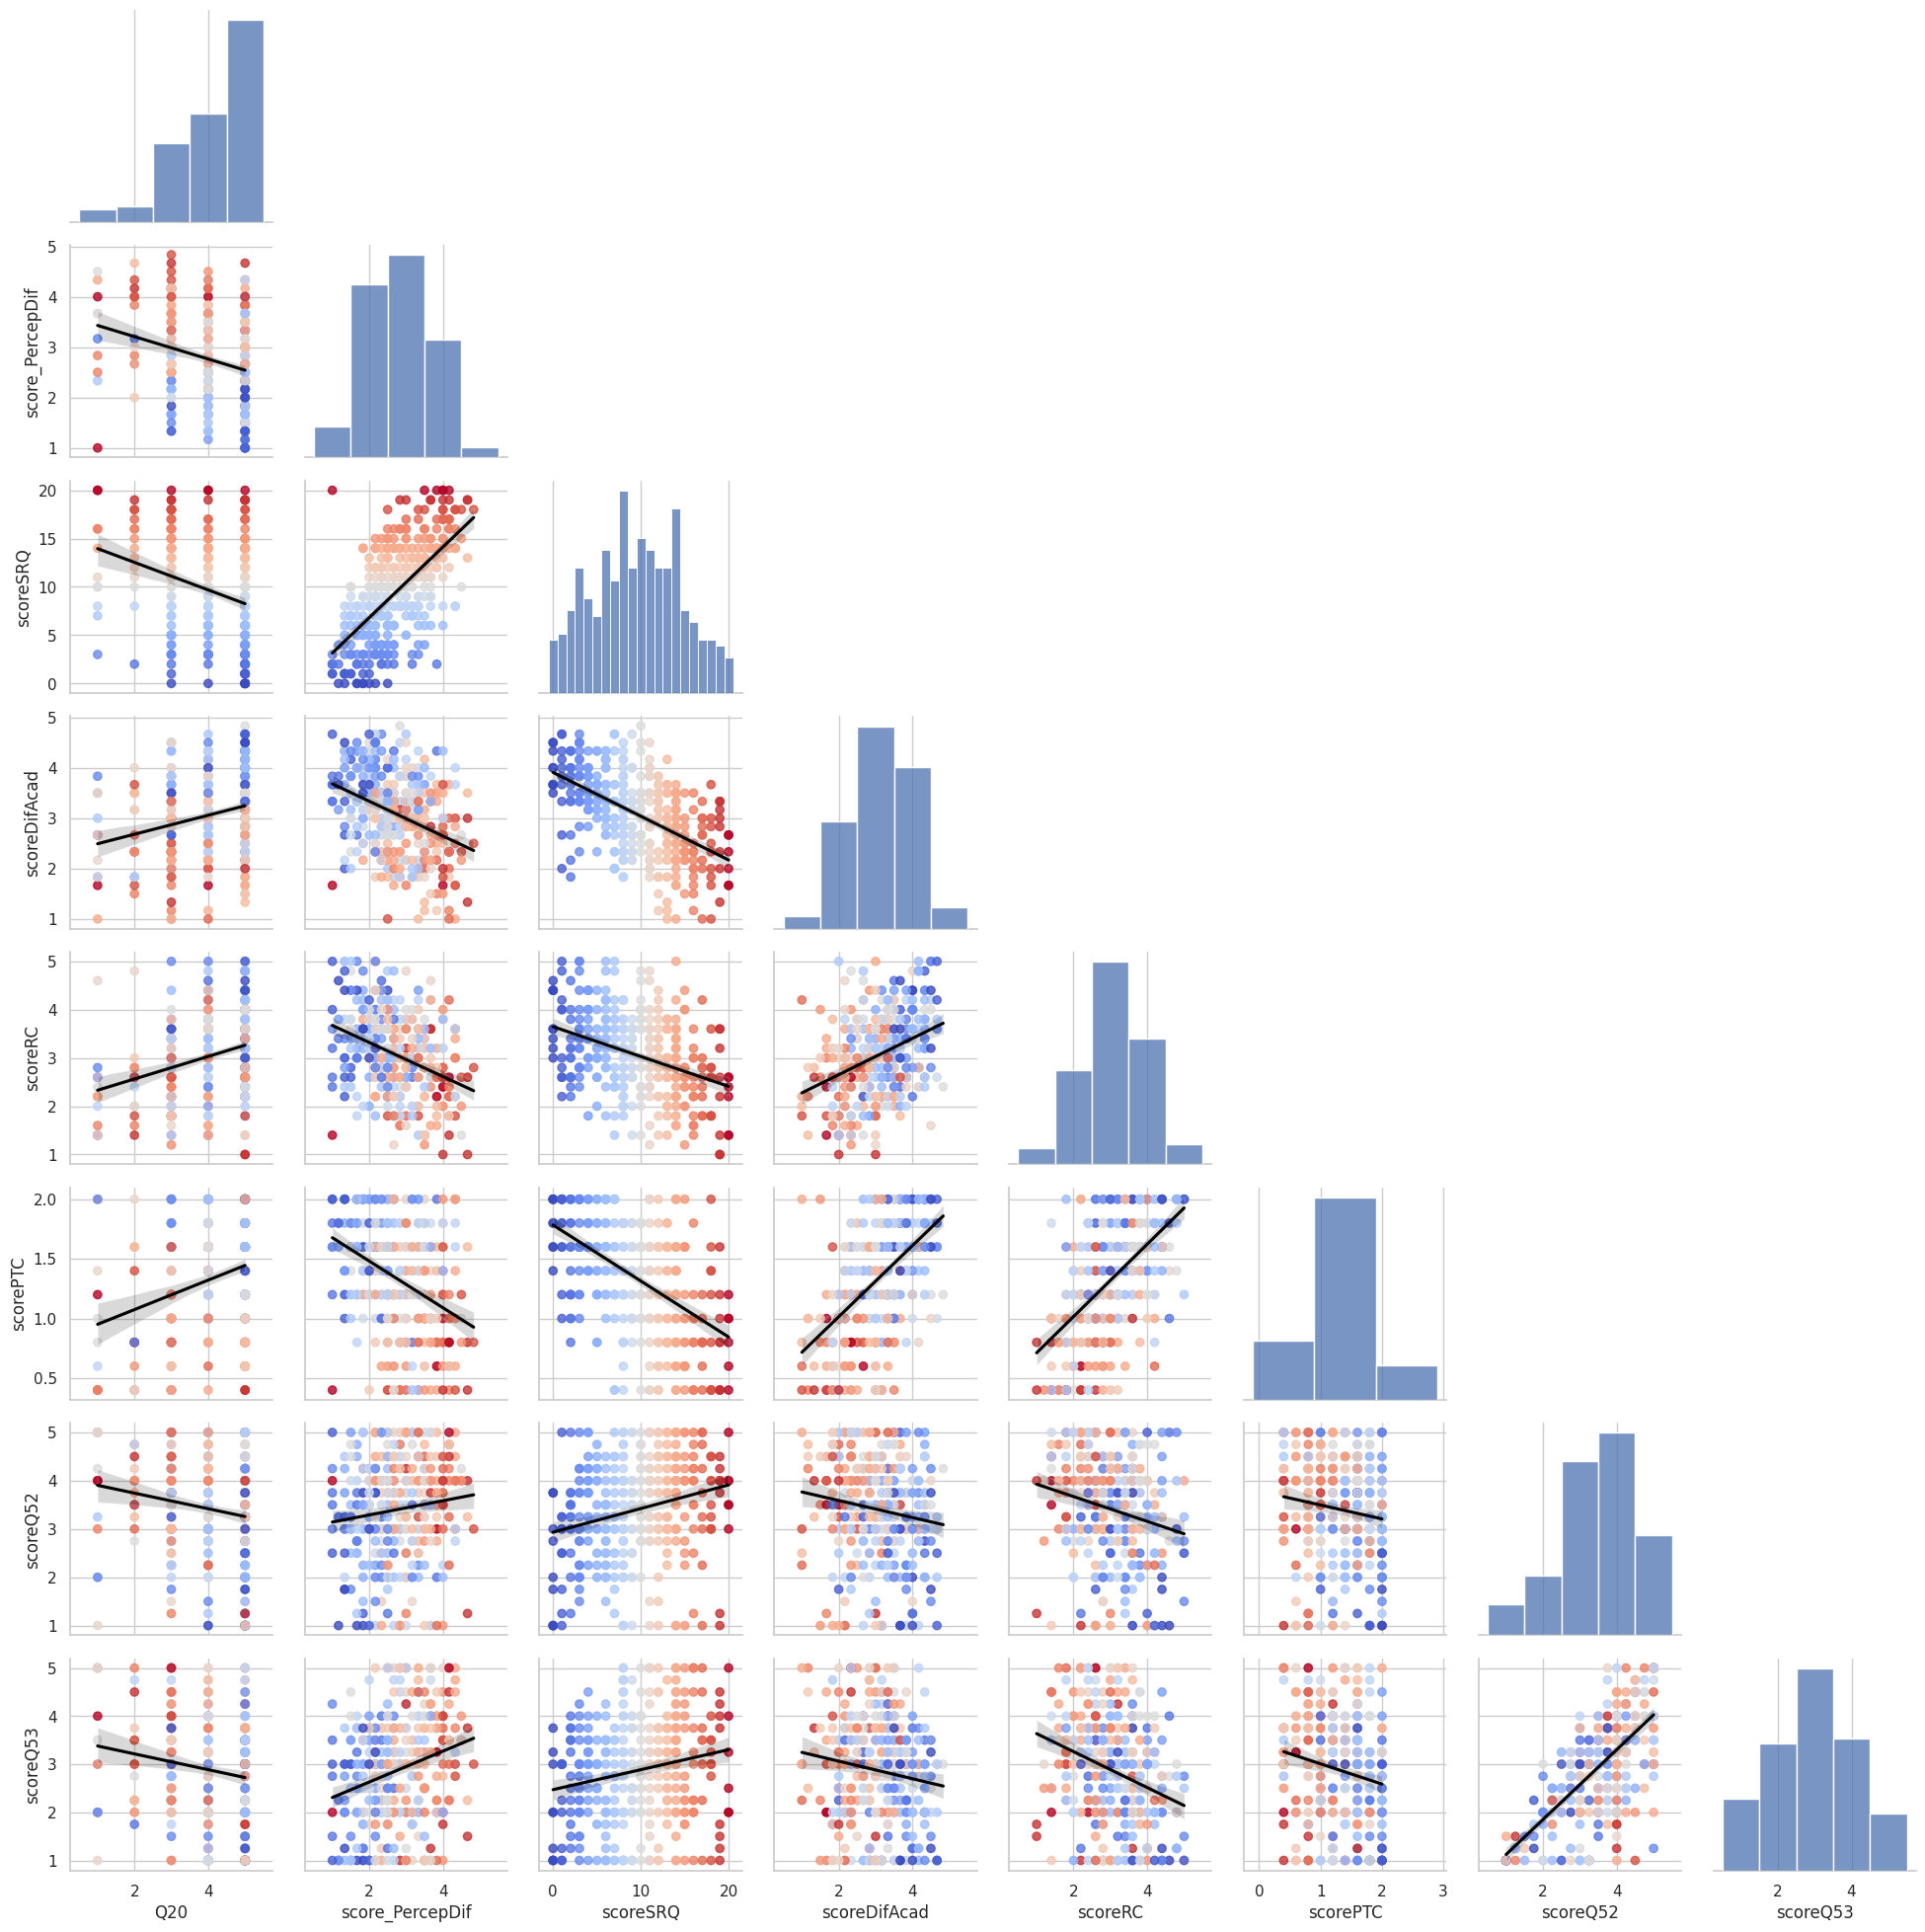

In [ ]:
# + 30 segundos para rodar
g = sns.PairGrid(df, diag_sharey=False, corner=True, vars = escala )
g.map_lower(sns.regplot,  scatter_kws={'c':df['scoreSRQ'], 'cmap':'coolwarm', 'color' : None} , line_kws={"color": "black"})
g.map_diag(sns.histplot, discrete = True )


Por último, ao realizar uma análise de correlação, idealmente reportaríamos o intervalo de confiança da estatística utilizada. Entretanto, até o momento, o SciPy não implementou nenhum método para obter uma estimativa intervalar para o coeficiente de correlação de tau. Uma alternativa é utilizar o bootstrap para gerar esse intervalo de confiança, que será nossa abordagem. Também poderíamos usar, como alternativa, alguma aproximação utilizando a distribuição normal.

In [ ]:
def get_kendall_bootstrap(data):
    resampled_data = resample(data, replace=True, n_samples=362)
    tau = kendalltau(resampled_data.iloc[:, 0], resampled_data.iloc[:, 1])[0]
    return tau

In [ ]:
def tau_confint(var1, var2, n_samples):
    dados_bootstrap = df.loc[:, [var1, var2]]
    tau_list = [get_kendall_bootstrap(dados_bootstrap) for i in range(n_samples)]
    return (f"({np.percentile(tau_list, 2.5)}, {np.percentile(tau_list, 97.5)})" , tau_list)

In [ ]:
boostrap_tau_scores_SQR = tau_confint("score_PercepDif","scoreSRQ", 10_000)

In [ ]:
boostrap_tau_scores_eQ52 = tau_confint("scoreQ52","score_PercepDif", 10_000)

In [ ]:
print(boostrap_tau_scores_SQR[0])

(0.40789911763835657, 0.5247827295240709)


In [ ]:
print(boostrap_tau_scores_eQ52[0])

(0.026448027841398863, 0.16696631285355926)


<Axes: ylabel='Count'>

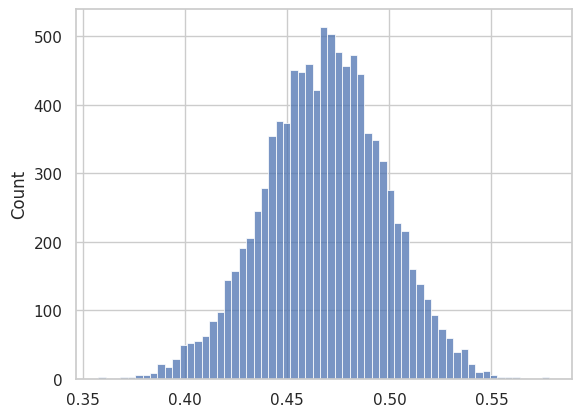

In [ ]:
sns.histplot(boostrap_tau_scores_SQR[1])

<Axes: ylabel='Count'>

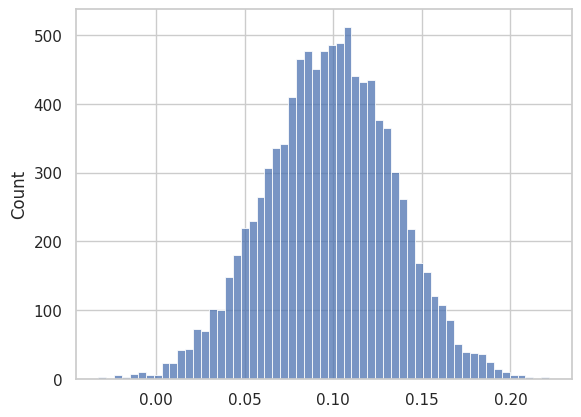

In [ ]:
sns.histplot(boostrap_tau_scores_eQ52[1])

As distribuições de Bootstrap obitdas se assemelham com a distribuição Normal, o que é um bom sinal para a convergência dos estimadores de erro e intervalos de confiança obtidos dessa reamostragem.

#### 3.2.2 Atributos categóricos

In [ ]:
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score

In [ ]:
var_categoricas = ['Q02', 'Q03', 'Q04', 'Q05', 'moradia','Q09',
       'Q11', 'Q15', 'Q17', 'Q19','Q21','nivelSRQ', 'Q10']

O coeficiente de incerteza é uma medida de associação que pode ser utilizada em associações do tipo nominal-nominal. Sua interpretação é a seguinte: indica a redução proporcional do erro quando os valores de uma variável são utilizados para prever os valores de outra variável. Por exemplo, um valor de 0,83 indica que o conhecimento de uma variável reduz o erro na previsão dos valores da outra em 83%. (Adaptado de [3], [4])

In [ ]:
def uncertainty_coefficient(row,column):
  I = mutual_info_score(df[row],df[column])
  H  = entropy(df[row].value_counts())
  return(I/H).round(3)

In [ ]:
matriz_metricas = np.zeros((len(var_categoricas), len(var_categoricas)))

for i, row in enumerate(var_categoricas):
    for j, column in enumerate(var_categoricas):
        matriz_metricas[i, j] = uncertainty_coefficient(row, column)

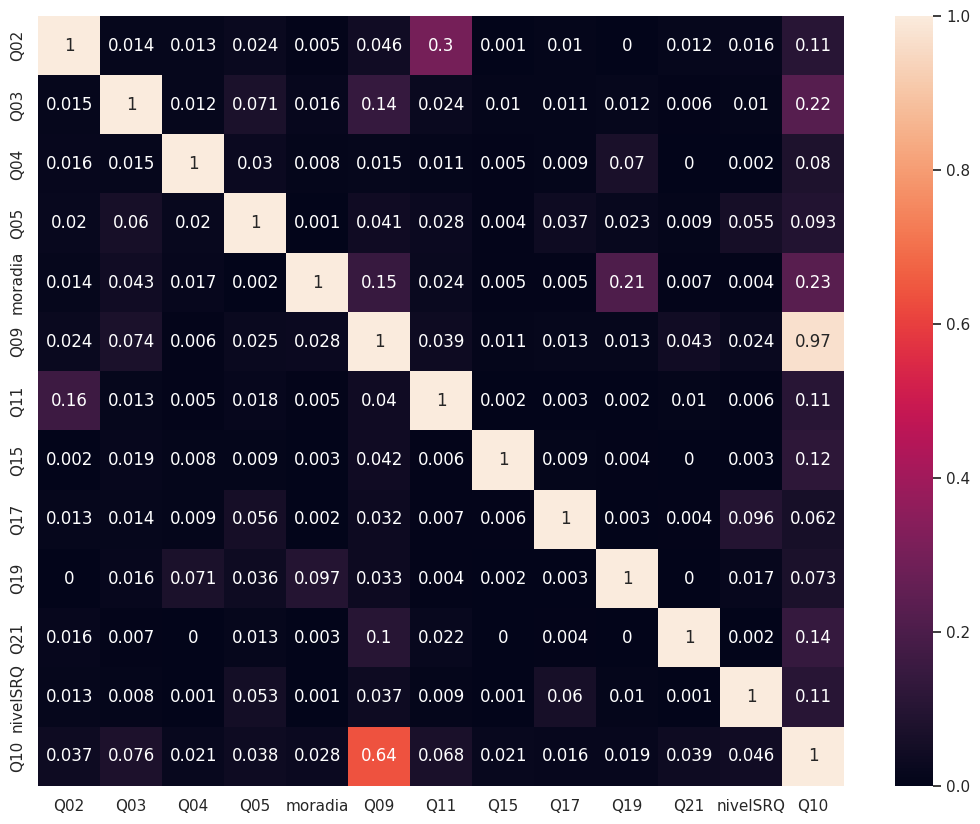

In [ ]:
uncertainty_coefficient_df = pd.DataFrame(matriz_metricas, columns = var_categoricas , index = var_categoricas)

plt.figure(figsize=(13, 10))
sns.heatmap(uncertainty_coefficient_df, annot= True)
plt.show()

In [ ]:
uncertainty_coefficient('Q09', 'Q10')

0.971

In [ ]:
uncertainty_coefficient('Q10', 'Q09')

0.639

 As associações mais relevantes encontradas entre as variáveis Q10 e Q09 mostram que saber a qual departamento um aluno pertence fornece informações sobre o curso no qual ele está matriculado, como poderiamos deduzir. Fora isso, nenhuma covariável é particularmente informativa das outras. Isso não impede que juntamente covariáveis tenham poder preditivo, mas, individualmente, nenhuma (fora o par Q10 e Q09) é particularmente informativo sobre as outras.




Finalmente, fazemos a separação de treino e teste:

In [ ]:
# from sklearn.model_selection import train_test_split
# X = df.drop("scoreSRQ", axis=1)
# y = df["scoreSRQ"]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12624912)

## 5. Conclusões

A partir da exploração visual e estatística dos dados básica que realizamos até agora, observamos que as covariáveis tem interrelações complexas entre sí, que nenhuma é particularmente informativa sobre as outras (o que, de certa forma, motiva o uso de uma modelagem mais complexa), mas que ainda existem correlações moderadas com informação a ser aproveitada.

Observamos, em geral, que o escore se comporta da forma esperada (mais escores no meio, razoávelmente simétrico). Já os resultados das questões não são tão simples: não há uma direção unidimensional para associar com o escore, mas diversas dimensões a serem consideradas. Um resultado marcante é que, quando elas existem, as relações entre as covariáveis são ruidosas, indicando possível multidimensionalidade, mas não particularmente não-lineares. Esperamos, portanto, que esse tipo de complexidade não seja o mais importante para tratarmos.

---


- [1]  Harrell Jr, Frank E. **Regression modeling strategies: with applications to linear models, logistic and ordinal regression, and survival analysis** (2015): 311-325.
- [2] STASINOPOULOS, Mikis D. et al. **Flexible regression and smoothing: using GAMLSS in R**. CRC Press, 2017.

* [3] https://www.statisticshowto.com/uncertainty-coefficient/. Acesso em 02/04/2024.

* [4] https://www.ibm.com/docs/en/spss-statistics/25.0.0?topic=crosstabs-statistics. Acesso em 02/04/2024.

In [ ]:
#!jupyter nbconvert --to pdf Cópia de Trabalho parte 1.ipynb

# Análise de agrupamento e redução de dimensionalidade

Parte 1 (Análise de agrupamentos)

* Escolher/comparar diferentes métodos de agrupamento. Os métodos mais comuns são agrupamento aglomerativo, k-means e DBSCAN.
* Após a aplicação do método, interpretar e verificar a distribuição do atributo de interesse nos clusters (nível SRQ). Isso é feito somente após o passo anterior.
* Discutir como utilizar os resultados encontrados pelos clusters.

Parte 2 (Análise multivariada)

* Aplicar métodos de análise multivariada para redução de dimensionaldiade (PCA, MCA, etc.).
* Justificar o método aplicado.
* Interpretar os resultados.
* Discutir como esse método será utilizado em análises futuras.

## PARTE 1

https://www.kaggle.com/code/halflingwizard/clustering-categorical-data-using-gower-distance#Gower-Distance
https://www.sciencedirect.com/science/article/abs/pii/S0925231217311815?via%3Dihub (seção 5)



**Objetivo** Segmentar os dados, segundo algum critério, buscando encontrar um "grupo de risco"

### Ambiente

In [ ]:
!pip install prince

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 415.6/415.6 kB 5.2 MB/s eta 0:00:00


In [ ]:
!pip install gower


In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import fcluster
import gower
from scipy.cluster import hierarchy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from scipy.spatial.distance import squareform
from scipy.stats import mannwhitneyu as WMW


In [ ]:
dicionario

Questão  \
0              Q02   
1              Q03   
2              Q04   
3              Q05   
4              Q06   
5          Moradia   
6              Q09   
7              Q10   
8              Q11   
9              Q13   
10             Q15   
11             Q17   
12             Q19   
13             Q20   
14             Q21   
15  scorePercepDif   
16        nivelSRQ   
17        scoreSRQ   
18    scoreDifAcad   
19         scoreRC   
20        scorePTC   
21        scoreQ52   
22        scoreQ53   

                                                                                                                                 Conteúdo  \
0                                                                                                                                   Idade   
1                                                                                                                                  Gênero   
2                                                                                                                              Raça/Etnia   
3                                                                                                                       Orientação sexual   
4                                                                                           Distância São Carlos- Endereço de procedência   
5                                                                                                    Mora ou não no alojamento estudantil   
6                                                                                                              Vínculo com a universidade   
7                                                                                                                      Curso de Graduação   
8                                                                                                                         Ano de ingresso   
9                                                                                              Exerce atividade remunerada além do estudo   
10                                                                                                    Possui diagnósticos em saúde física   
11                                                                                                    Possui diagnósticos em saúde mental   
12                                                                                                     Recebe auxílio permanência (PAPFE)   
13   Possui as condições adequadas para minha permanência material na graduação (moradia, alimentação, transporte, custos materiais, etc)   
14                                                                                                           Conhece o Apoia USP ou GAPsi   
15                                                                               score sobre percepção de dificuldades (sentido negativo)   
16                                                              De acordo com o scoreSRQ, classificação da soma do SQR em níveis de risco   
17                                                        score sobre o risco de desenvolver transtornos mentais SRQ20 (sentido negativo)   
18                                                                                   score sobre dificuldade acadêmica (sentido positivo)   
19                                                                  score sobre relações e comunicação na universidade (sentido positivo)   
20                                                                           score sobre pertencimento na universidade (sentido positivo)   
21                                                                         score sobre discriminação da USP São Carlos (sentido negativo)   
22                                                                      score sobre discriminação da unidade de ensino (sentido negativo)   

   Tipo do atributo  \
0        Categórica   
1        Categórica   
2        Categórica   
3    

### Dendogramas

Os métodos de clustering fazem parte das técnicas de aprendizado não supervisionado, no sentido de que não precisamos de rótulos para ajustar esses métodos. O objetivo dos métodos de clustering é agrupar os dados em "clusters", onde as observações dentro de cada cluster sejam semelhantes entre si. Além disso, é desejável que os clusters sejam distintos entre si, representando diferentes características do conjunto de dados.

A estratégia de clustering utilizada neste trabalho é o cluster hierárquico aglomerativo, em que inicialmente cada observação do conjunto de dados é considerada um cluster individual. As observações são, então, agrupadas iterativamente em clusters maiores até que haja somente um único cluster contendo todas as observações.


Antes de aplicar o método de clustering, é necessário definir uma matriz de distâncias para medir a distância entre as observações, bem como um método de ligação (linkage method) para determinar a distância entre os clusters. A distância escolhida foi a distância de Gower, que é adequada para bases de dados contendo tanto atributos categóricos quanto numéricos. Resumidamente, essa distância considera uma ponderação entre a "Distância de Dice" para calcular a distância entre atributos categóricos e a distância de Manhattan para calcular a distância entre atributos numéricos (veja [2] e [3])

Alternativamente, poderíamos categorizar os atributos numéricos e optar por uma medida de dissimilaridade para atributos categóricos, como a dissimilaridade coseno ou outra medida adequada. No entanto, essa alternativa não foi adotada por introduzir pelo menos dois problemas adicionais: (1) Encontrar uma maneira eficiente de categorizar atributos numéricos, considerando que muitos atributos utilizam escalas definidas pelo pesquisador, e esses métodos de categorização podem destruir essas escalas; (2) Lidar com o viés introduzido pela discretização: como determinar se um método para discretizar atributos é eficiente? Se eu obtenho dois clusters diferentes discretizando o mesmo atributo com métodos de discretização diferentes, o que devo concluir : que o método de cluster é ineficiente ou que o método de discretização é ineficiente ?


Por fim, consideramos dois métodos de ligação: Ward Linkage e Complete Linkage. O método Ward Linkage minimiza a variância total dentro de cada cluster, enquanto o método Complete Linkage considera a distância máxima entre os elementos dentro do cluster.

Para fins de consulta  a "dice distance "é definida como" (veja [4] e [3]):


$\text{Dice distance}(A, B) =  \frac{2 \times |A \cap B|}{|A| + |B|}$


Em que $|.|$ corresponde a cardinalidade  do conjunto

A distância de "Manhattan Distance" é definida como :

$\text{Manhattan distance} = \sum_{i=1}^{n} |x_{i} - y_{i}|$


[1] Russo, Cibele. Aula10a Análise de Agrupamentos. 2020. Disponível em: https://www.youtube.com/watch?v=zyLDAnQMnbo . Acesso em: 20 maio 2024.

[2]  Divyanshu Anand. Gower’s Distance. Disponível em: https://medium.com/analytics-vidhya/gowers-distance-899f9c4bd553. Acesso em: 20 maio 2024


[3]GOWER, John C. A general coefficient of similarity and some of its properties. Biometrics, p. 857-871, 1971.

[4] https://en.wikipedia.org/wiki/Dice-S%C3%B8rensen_coefficient

In [ ]:
# Processamento dos dados
# Remove nas da questão 13 seguindo sugestão da pesquisadora
# Removemos o ID e a variável alvo
# A distância é normalizada, para qua influência no valor da distância nao seja muito alto
df['Q13'] = df['Q13'].fillna('outros')
X = df.drop(['nivelSRQ','  ID','scoreSRQ'], axis = 1)
X['Q06'] = StandardScaler().fit_transform(X[['Q06']])
distance_matrix = gower.gower_matrix(X)
condensed_distance_matrix = squareform(distance_matrix)

In [ ]:
# ajuste dos cluster
clustering_complete = hierarchy.linkage(condensed_distance_matrix, method='complete')
clustering_ward = hierarchy.linkage(condensed_distance_matrix, method='ward')


In [ ]:
# Função para visualizar o corte
def visualizar_corte(cluster,altura,metodo):
  '''
  Cluster:  um objeto da classe scipy.cluster.hierarchy
  Altura: A altura para realizar o corte
  Metodo : O método utilizado (que irá aparecer no titulo)
  '''
  plt.figure(figsize=(10.5, 7.5))
  dn = hierarchy.dendrogram(cluster, color_threshold=altura, no_labels = True)
  plt.title(f'Dendrograma método {metodo} com corte na altura {altura}')
  plt.axhline(y= altura, linestyle='--', color='Grey')
  plt.tight_layout()
  plt.show()

#### Ward

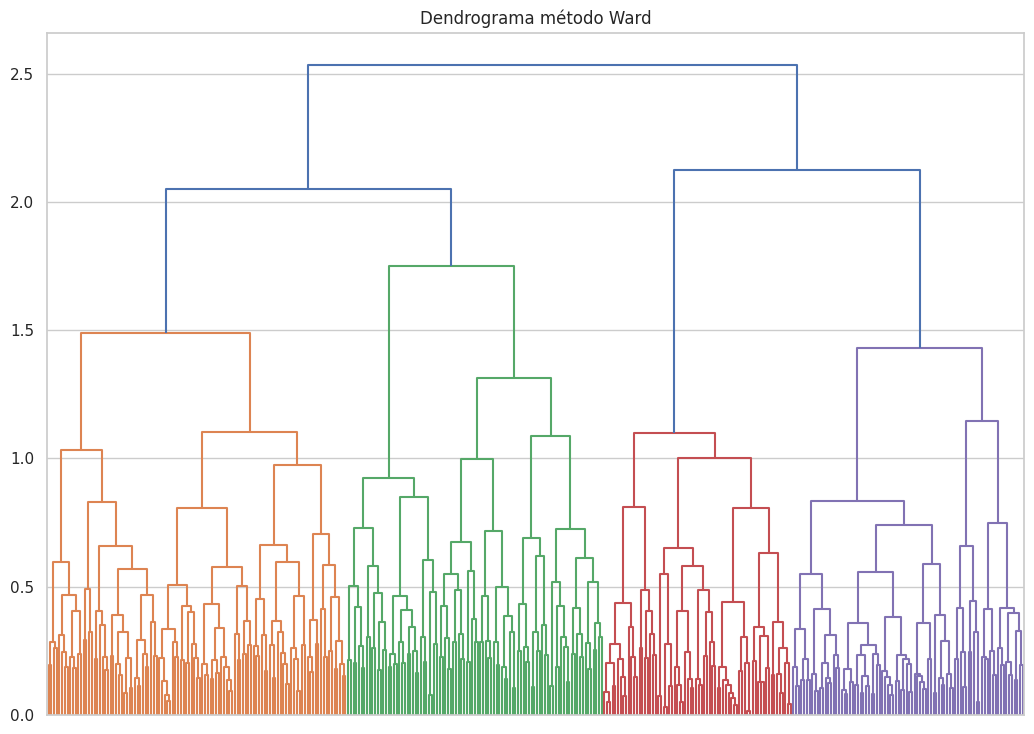

In [ ]:
plt.figure(figsize=(10.5, 7.5))
dn = hierarchy.dendrogram(clustering_ward, color_threshold=None, no_labels = True)
plt.title('Dendrograma método Ward')
plt.tight_layout()
plt.show()

O gráfico acima apresenta um dendograma para um cluster aglomerativo, utilizando a distância gower e  o método ward. A seguir vamos realizar os cortes no dengroama, para determinar os clusters

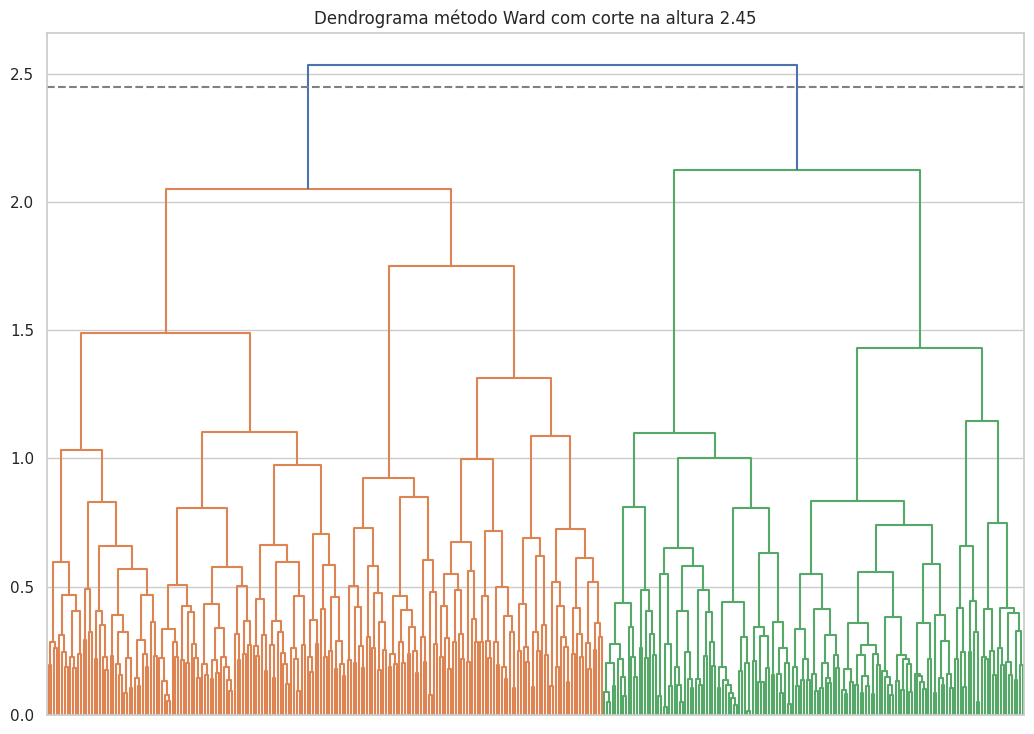

In [ ]:
visualizar_corte(clustering_ward, 2.45,'Ward')

O primeiro corte, na altura 2.45, resulta em 2 clusters


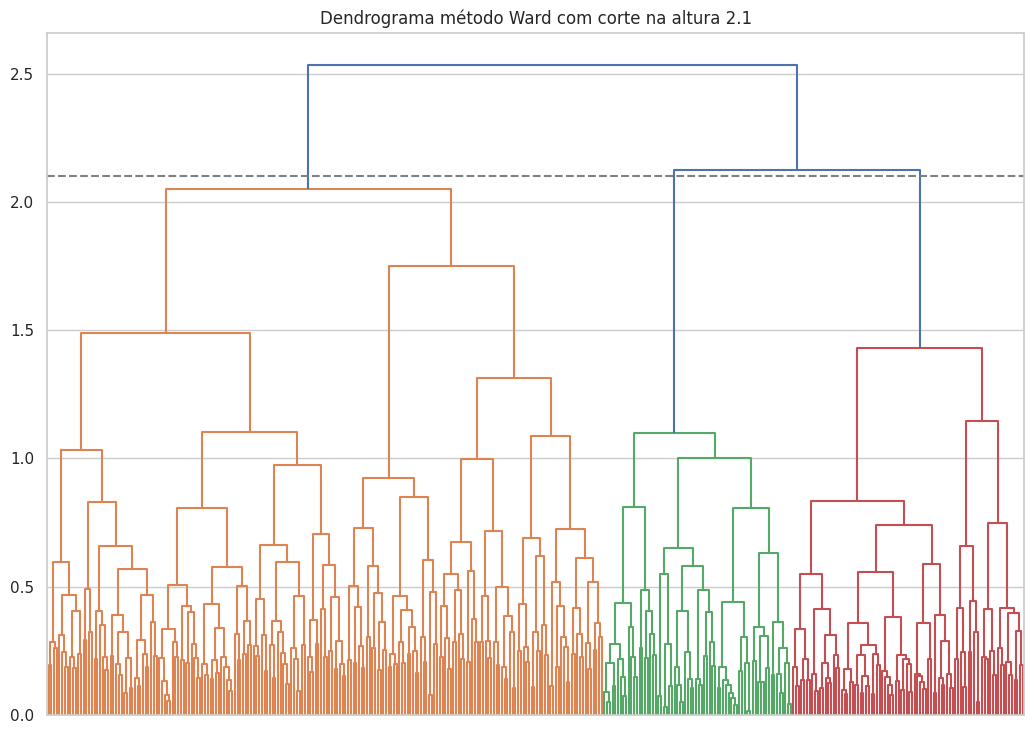

In [ ]:
visualizar_corte(clustering_ward, 2.1,'Ward')

O segundo  corte, na altura 2.1, resulta em 3 clusters.


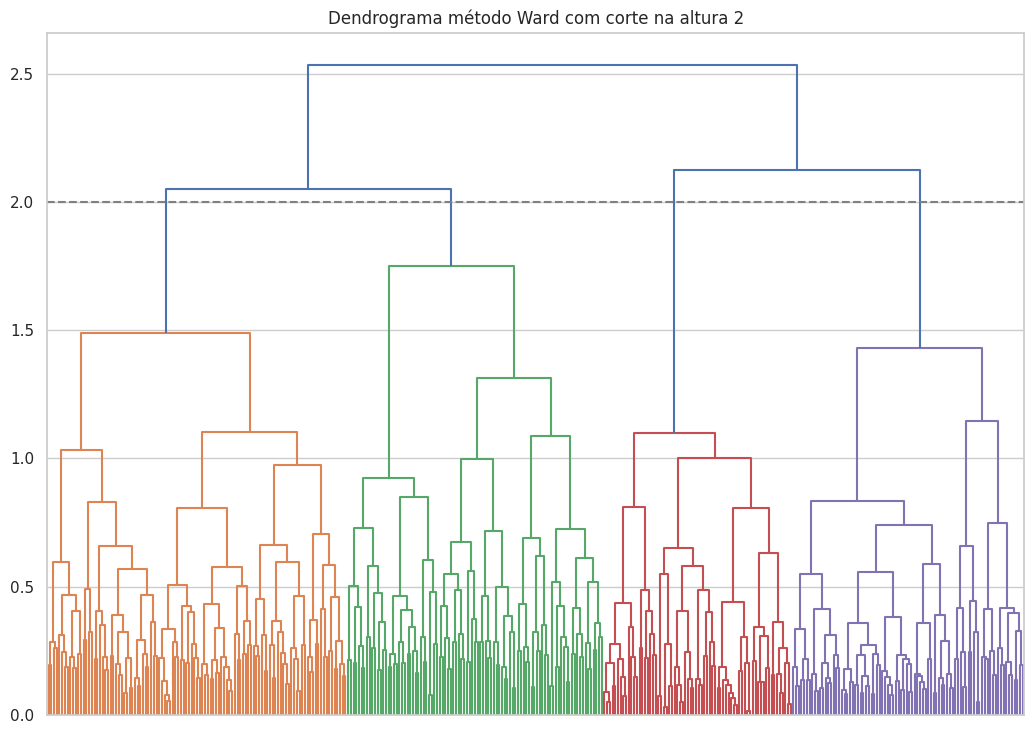

In [ ]:
visualizar_corte(clustering_ward, 2,'Ward')

O segundo  corte, na altura 2.0 resulta em 4 clusters.


#### Complete

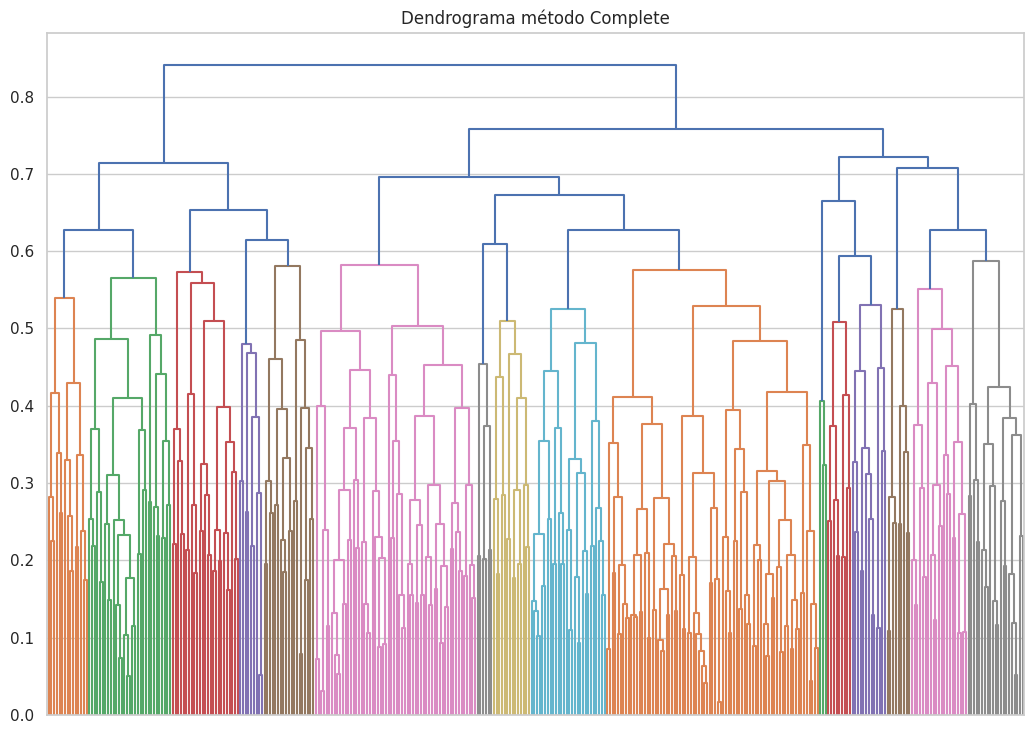

In [ ]:
plt.figure(figsize=(10.5, 7.5))
dn = hierarchy.dendrogram(clustering_complete, color_threshold=None, no_labels = True)
plt.title('Dendrograma método Complete')
plt.tight_layout()
plt.show()

O gráfico acima apresenta o resultado de um agrupamento hierárquico utilizando o método aglomerativo, a distância de Gower e a função de ligação ward. Nele foram propostos os seguintes cortes:


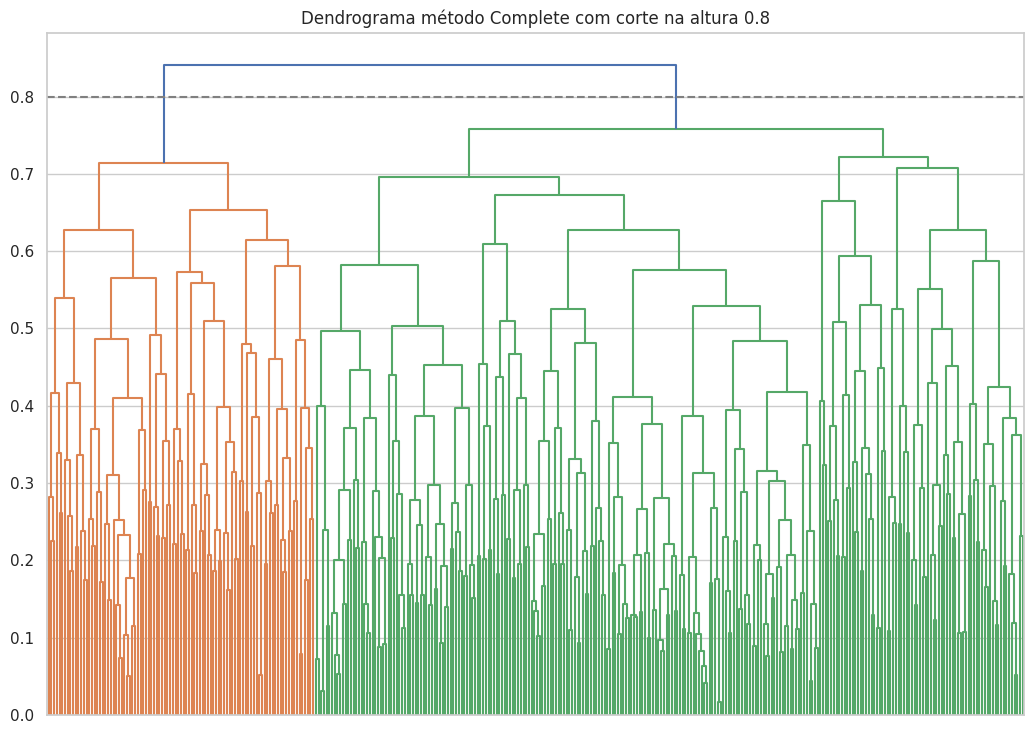

In [ ]:
visualizar_corte(clustering_complete, 0.8,'Complete')

O primeiro corte na altura 0.8 resulta em 2 clusters

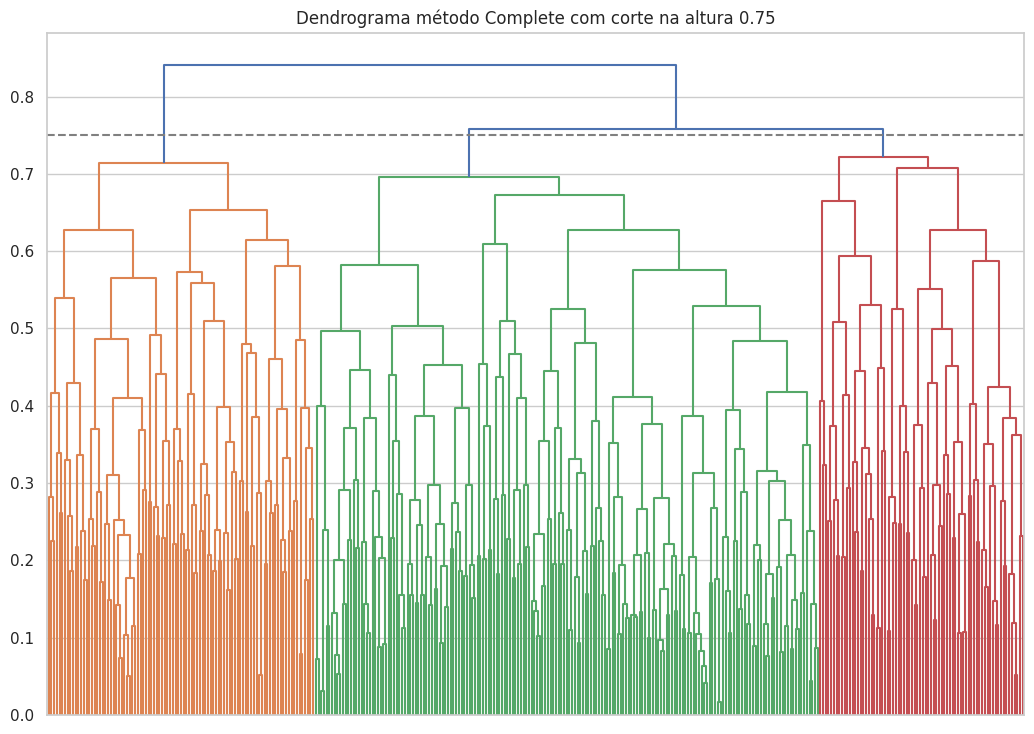

In [ ]:
visualizar_corte(clustering_complete, 0.75,'Complete')

O segundo corte na altura 0.75 resulta em 3 clusters

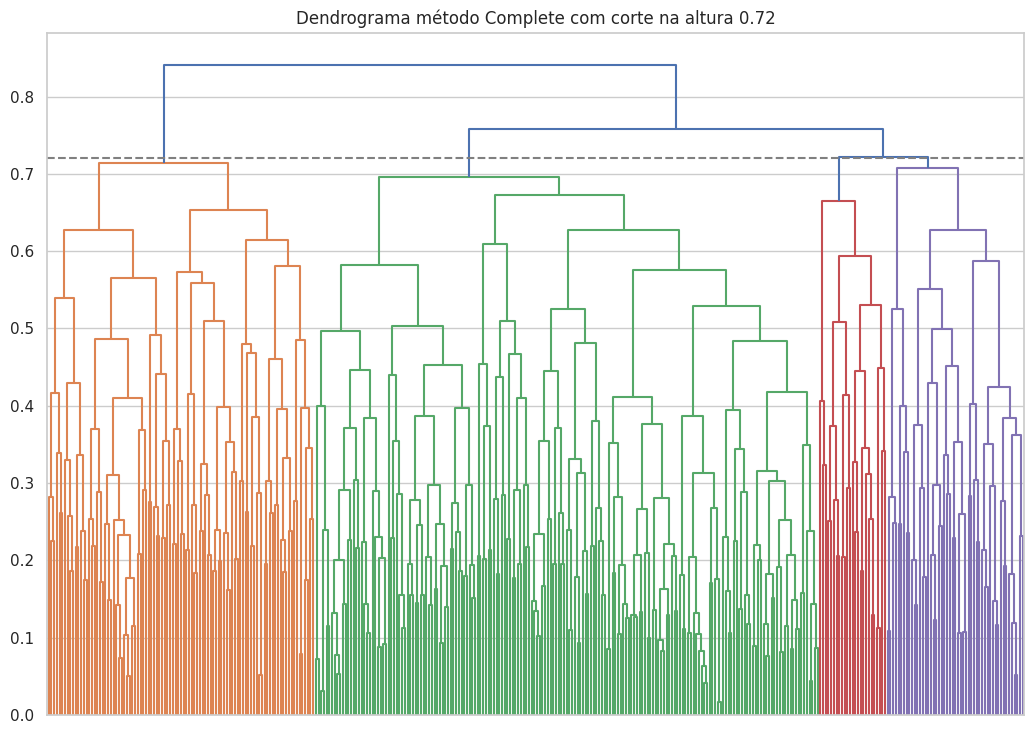

In [ ]:
visualizar_corte(clustering_complete, 0.72,'Complete')

O segundo corte na altura 0.75 resulta em 4 clusters

### Escolha do método de cluster

Como há multiplas opções para conseguir os clusters, é preciso decidir qual delas utilizar.
https://www.sciencedirect.com/science/article/abs/pii/S0925231217311815?via%3Dihub (seção 5)


https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation (seção 2.3.11.)


* **Internal Criteria**: São métricas que avaliam a qualidade da representação dos clusters sem a necessidade de ter alguma rotulação. Em geral, são avaliadas focando na semelhança entre os elementos do cluster (compactabilidade) e na diferença entre observações de clusters distintos (separabilidade).
  * **silhouette_score**: Este coeficiente varia de -1 (representação ruim) a 1 (boa representação) e mede o quão similar um ponto é aos outros pontos no mesmo cluster, comparado com pontos em outros clusters.

* **External Quality Criteria Measures**: Quando um conjunto de rótulos está disponível, podemos utilizá-los para avaliar a representação gerada pelo cluster.
  * **rand_score**: Mede a similaridade entre os rótulos e a representação encontrada pelo cluster.
  * **v_measure_score**: Avalia conjuntamente a homogeneidade (se os clusters têm exemplos predominantemente de uma mesma classe) e a completude (se as observações de uma dada classe são atribuídas ao mesmo cluster).

In [ ]:
from sklearn.metrics import v_measure_score ,adjusted_rand_score , silhouette_score
from scipy.stats import chi2_contingency


In [ ]:
def get_metrics(cluster , altura):
  labels_cluster  =   fcluster(cluster, t = altura, criterion='distance')
  true_labels = df['nivelSRQ']
  return np.array([ v_measure_score(true_labels ,labels_cluster) ,  adjusted_rand_score(true_labels ,labels_cluster) , silhouette_score(distance_matrix, labels_cluster)])




In [ ]:
cluster_metric = np.vstack( [get_metrics(clustering_ward, 2.45) ,
                              get_metrics(clustering_ward, 2.1) ,
                              get_metrics(clustering_ward, 2),
                              get_metrics(clustering_complete, 0.8) ,
                              get_metrics(clustering_complete, 0.75) ,
                              get_metrics(clustering_complete, 0.72),
                              ])

In [ ]:
cluster_metric = pd.DataFrame(cluster_metric,
                              columns =  ['v_measure_score' , 'adjusted_rand_score' , 'silhouette_score'] ,
                              index = ['Ward_corte1', 'Ward_corte2', 'Ward_corte3', 'complete_corte1', 'complete_corte2', 'complete_corte3'])

In [ ]:
cluster_metric.sort_values(by = 'silhouette_score', ascending =  False)

v_measure_score  adjusted_rand_score  silhouette_score
Ward_corte1             0.014639             0.006614          0.102963
complete_corte2         0.063273             0.047837          0.087704
Ward_corte3             0.033292             0.019948          0.079061
Ward_corte2             0.015116            -0.001700          0.077296
complete_corte3         0.071194             0.046115          0.069082
complete_corte1         0.071718             0.059889          0.056150

In [ ]:
cluster_metric.sort_values(by = 'v_measure_score', ascending =  False)

v_measure_score  adjusted_rand_score  silhouette_score
complete_corte1         0.071718             0.059889          0.056150
complete_corte3         0.071194             0.046115          0.069082
complete_corte2         0.063273             0.047837          0.087704
Ward_corte3             0.033292             0.019948          0.079061
Ward_corte2             0.015116            -0.001700          0.077296
Ward_corte1             0.014639             0.006614          0.102963

In [ ]:
cluster_metric.sort_values(by = 'adjusted_rand_score', ascending =  False)

v_measure_score  adjusted_rand_score  silhouette_score
complete_corte1         0.071718             0.059889          0.056150
complete_corte2         0.063273             0.047837          0.087704
complete_corte3         0.071194             0.046115          0.069082
Ward_corte3             0.033292             0.019948          0.079061
Ward_corte1             0.014639             0.006614          0.102963
Ward_corte2             0.015116            -0.001700          0.077296

### Interpretação


De posse dos melhores clusters, o próximo passo é interpretar os resultados e selecionar uma representação para desenvolver uma análise mais profunda. Como o interesse deste trabalho é estudar os riscos associados aos transtornos mentais, buscamos interpretar os clusters fazendo um paralelo com o risco de doenças mentais, procurando por clusters que "identifiquem" indivíduos sob risco.

#### Construção do perfil de risco

In [ ]:
def get_cluster_df(cluster, altura_corte):
    '''
    cluster - um cluster ajustado por scipy.hierarchy
    altura_corte - altura de corte para cortar o dendrograma
    Retorna um data frame com uma coluna extra cluster_label, que corresponde aos labels gerados pelo método de clustering
    '''
    labels = fcluster(cluster, altura_corte, criterion='distance')
    X_cluster = X.copy()
    X_cluster['nivelSRQ'] = df['nivelSRQ']
    X_cluster['scoreSRQ'] = df['scoreSRQ']
    X_cluster['cluster_label'] = labels
    return X_cluster

In [ ]:
# Seleciona com base nas métricas
X_cluster_silhouette_score = get_cluster_df(clustering_ward,2.45)
X_cluster_other_metrics = get_cluster_df(clustering_complete,0.8)


##### Primeiro cluster

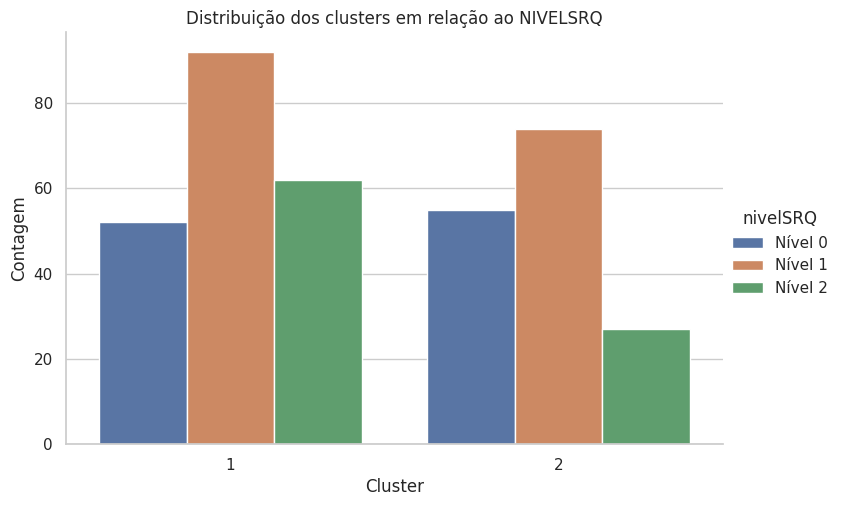

In [ ]:
# verifica a distribuicao no cluster
sns.catplot(x='cluster_label', hue='nivelSRQ', data=X_cluster_silhouette_score, kind='count', height=5, aspect=1.5, hue_order=['Nível 0', 'Nível 1', 'Nível 2'])
plt.xlabel('Cluster')
plt.ylabel('Contagem')
plt.title('Distribuição dos clusters em relação ao NIVELSRQ')
plt.show()

In [ ]:
pd.crosstab(X_cluster_silhouette_score['nivelSRQ'] , X_cluster_silhouette_score['cluster_label'] , margins  = True)

cluster_label    1    2  All
nivelSRQ                    
Nível 0         52   55  107
Nível 1         92   74  166
Nível 2         62   27   89
All            206  156  362

Apresentamos uma tabela de contigência com os totais marginais. Note que há uma diferença na quantidade de invdivíduos nos clusters quando o  nível 2 é considerado

In [ ]:
pd.crosstab(X_cluster_silhouette_score['nivelSRQ'] , X_cluster_silhouette_score['cluster_label'] , normalize   = 'columns')

cluster_label         1         2
nivelSRQ                         
Nível 0        0.252427  0.352564
Nível 1        0.446602  0.474359
Nível 2        0.300971  0.173077

Apresentamos uma tabela de contigência normalizado pelas colunas . Note que há uma diferença na quantidade de invdivíduos nos clusters quando o  nível 2 é considerado

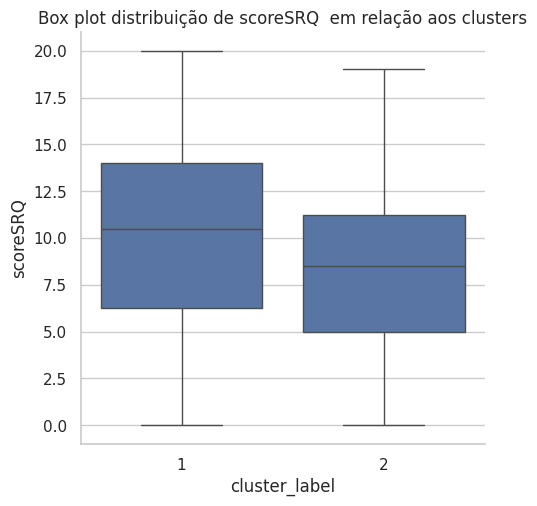

count       mean       std  min   25%   50%    75%   max
cluster_label                                                          
1              206.0  10.296117  5.139487  0.0  6.25  10.5  14.00  20.0
2              156.0   8.455128  4.602023  0.0  5.00   8.5  11.25  19.0

In [ ]:
sns.catplot(x='cluster_label', y = 'scoreSRQ', data=X_cluster_silhouette_score, kind='box')
plt.title('Box plot distribuição de scoreSRQ  em relação aos clusters')
plt.show()

X_cluster_silhouette_score.groupby('cluster_label')['scoreSRQ'].describe()


Apresentamos os boxplots e a tabela resumo com estatísticas descritivas. Note que o grupo de risco tem mediana e média do scoreSRQ20 maior do que o do grupo 1.


Pode-se notar que, ao menos em primeira análise, há uma diferença quanto ao nível do risco de desenvolver doença mental (nível SRQ). Essa diferença parece ser maior para o nível 3 (maior risco), que está mais presente no cluster 1, o que pode ser notado pela tabela de contingência acima (que é normalizada por coluna). Por conseguinte, isso se reflete no gráfico de SCORSQR, onde a mediana dos scores do cluster 1 é maior do que a do cluster 2. Note, contudo, que não há muita diferença entre os níveis 0 e 1, tanto pelo gráfico quanto pela análise de contingência, a distribuição desses níveis não parece ser diferente dado dos clusters.


O teste do qui-quadrado pode ser utilizado para verificar se há uma relação entre duas variáveis nominais. Nesse caso, queremos ver se há relação entre o nível de transtorno mental (nível SRQ) e os clusters. Nesse sentido, definem-se as seguintes hipóteses, de maneira informal:

* $H_{0}$: Não há relação entre Cluster e nível SRQ.
* $H_{1}$: Há relação entre Cluster e nível SRQ.

In [ ]:
tab = pd.crosstab(X_cluster_silhouette_score['nivelSRQ'] , X_cluster_silhouette_score['cluster_label'])
teste_chi_square = chi2_contingency(tab)
print(f'\n Estatística chi-quadrado {teste_chi_square.statistic.round(3)} \n g.l : {teste_chi_square.dof} \n p valor : {teste_chi_square.pvalue.round(3)} ')


 Estatística chi-quadrado 9.067 
 g.l : 2 
 p valor : 0.011 


In [ ]:
# identifica o grupo de risco
X_cluster_silhouette_score['cluster_label']  = X_cluster_silhouette_score['cluster_label'].replace({1 : 'Grupo de risco' , 2 : 'Grupo 1'})

Ao nível de significância de 0,05, concluímos que há evidências contra a hipótese nula. Ou seja, há evidência de que há relação entre os labels dos clusters e o nível SRQ. Pela análise gráfica, identificamos um grupo de risco e outro grupo que, por simplicidade, optamos por não nomear.


##### Segundo cluster

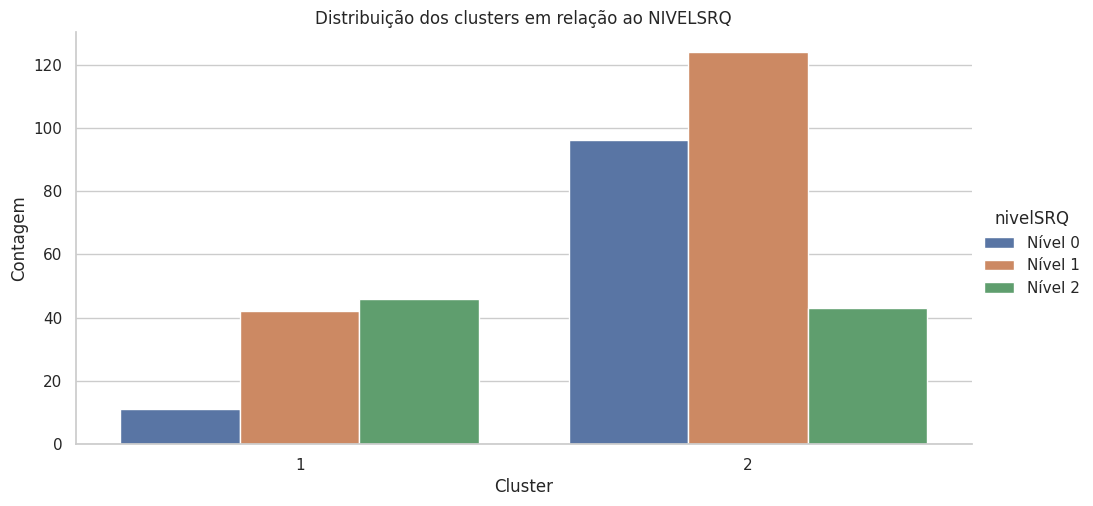

In [ ]:
sns.catplot(x='cluster_label', hue='nivelSRQ', data=X_cluster_other_metrics, kind='count', height=5, aspect=2, hue_order=['Nível 0', 'Nível 1', 'Nível 2'])
plt.xlabel('Cluster')
plt.ylabel('Contagem')
plt.title('Distribuição dos clusters em relação ao NIVELSRQ')
plt.show()

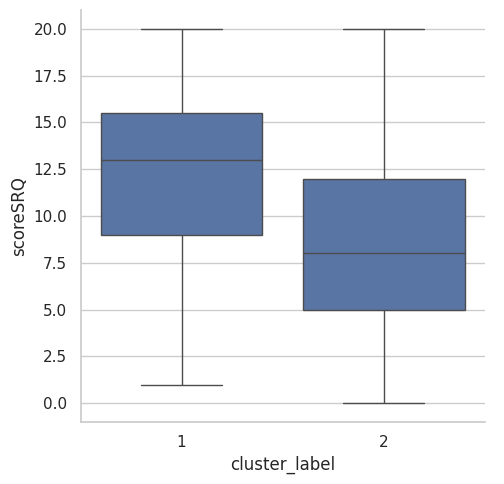

In [ ]:
sns.catplot(x='cluster_label', y = 'scoreSRQ', data=X_cluster_other_metrics, kind='box')


In [ ]:
pd.crosstab(X_cluster_other_metrics['nivelSRQ'] , X_cluster_other_metrics['cluster_label'] , margins  = True)

cluster_label   1    2  All
nivelSRQ                   
Nível 0        11   96  107
Nível 1        42  124  166
Nível 2        46   43   89
All            99  263  362

Apresentamos uma tabela de contingência com os totais marginais. Note que o cluster 2 é maior que o cluster 1, mas mesmo assim o cluster 1 tem mais indivíduos no nível 2, indicando que pode haver indivíduos com maior risco de transtorno mental nesse cluster

In [ ]:
pd.crosstab(X_cluster_other_metrics['nivelSRQ'] , X_cluster_other_metrics['cluster_label'], normalize=  'columns').round(3)

cluster_label      1      2
nivelSRQ                   
Nível 0        0.111  0.365
Nível 1        0.424  0.471
Nível 2        0.465  0.163

Apresentamos uma tabela de contingência normalizada pelas colunas. Aqui é muito evidente a diferença na distribuição entre os níveis 0 e 2 de transtorno mental. O cluster 1 tem uma proporção maior de indivíduos com baixo risco (nível 1), enquanto o cluster 2 tem uma proporção maior de indivíduos com um nível mais alto de transtorno mental (nível 2).


O teste do qui-quadrado pode ser utilizado para verificar se há uma relação entre duas variáveis nominais. Nesse caso, queremos ver se há relação entre o nível de transtorno mental (nível SRQ) e os clusters. Nesse sentido, definem-se as seguintes hipóteses, de maneira informal:

* $H_{0}$: Não há relação entre Cluster e nível SRQ.
* $H_{1}$: Há relação entre Cluster e nível SRQ.

In [ ]:
tab_2 = pd.crosstab(X_cluster_other_metrics['nivelSRQ'] , X_cluster_other_metrics['cluster_label'])
teste_chi_square_2 = chi2_contingency(tab_2)
print(f'\n Estatística chi-quadrado {teste_chi_square_2.statistic.round(3)} \n g.l : {teste_chi_square_2.dof} \n p valor : {teste_chi_square_2.pvalue.round(3)} ')


 Estatística chi-quadrado 42.569 
 g.l : 2 
 p valor : 0.0 


In [ ]:
# identifica o grupo de risco
X_cluster_other_metrics['cluster_label']  = X_cluster_other_metrics['cluster_label'].replace({1 : 'Grupo de risco' , 2 : 'Grupo 1'})

Ao nível de significância de 0,05, concluímos que há evidências contra a hipótese nula. Ou seja, há evidência de que há relação entre os labels dos clusters e o nível SRQ. Pela análise gráfica, identificamos um grupo de risco e outro grupo que, por simplicidade, optamos por não nomear.


#### **Análise do perfil de risco**



##### Escolha da representação

Concluímos que há evidência de uma associação entre o nível SQR e o clusters estudados. O próximo passo é medir essa associação e escolher, caso seja observada uma grande diferença, entre um dos dois clusters.
Uma medida de correlação para variáveis categóricas é o coeficiente de Cramer V, que varia de 0 (sem correlação) a 1 (correlação perfeita). Veja [1] e [2] para mais detalhes sobre  o Crámer V

In [ ]:
# Veja formula nas referencias
ward_value = np.sqrt(9.067 / 362)
complete_value = np.sqrt(42.569 / 362)

print(f'Cramér\'s V: \nCluster Ward: {ward_value:.4f} \nCluster Complete: {complete_value:.4f}')


Cramér's V: 
Cluster Ward: 0.1583 
Cluster Complete: 0.3429


A correlação do cluster completo é bem maior do que a do cluster Ward. Vamos optar por analisar o risco gerado por esses clusters (indivíduos no primeiro cluster)

In [ ]:
X_cluster_other_metrics['cluster_label'].value_counts()

cluster_label
Grupo 1           263
Grupo de risco     99
Name: count, dtype: int64

[1] https://www.statology.org/interpret-cramers-v/



[2] https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

##### Uma caracterização do perfil de risco

###### categórica

Para a variável categórica, realizamos a análise da tabela de contingência entre essa variável e os rótulos atribuídos pelos clusters. Utilizamos um teste qui-quadrado para verificar a independência entre os rótulos atribuídos pleos clusters e a variável categórica. Além disso, empregamos o coeficiente de Cramér V para quantificar a força dessa associação entre as variáveis categóricas.

OBS : As tabelas de contigência utilizadas são normalizadas pelas colunas

In [ ]:
def get_cramer(var):
  tab_ = pd.crosstab(X_cluster_other_metrics[var] , X_cluster_other_metrics['cluster_label'])
  chi2, p, dof, _ = chi2_contingency(tab_)
  denominador = np.min([len(X_cluster_other_metrics['cluster_label'].unique()) - 1, len(X_cluster_other_metrics[var].unique()) - 1])
  numerador = chi2/362
  cramer = np.round(np.sqrt(numerador/ denominador),3)
  sig = p < 0.05
  p_ = np.round(p, 3)
  return np.array( [cramer ,dof , p_, sig ])


In [ ]:
def chi_square_test(var):
  tab_ = pd.crosstab(X_cluster_other_metrics[var] , X_cluster_other_metrics['cluster_label'])
  teste_chi_square_ = chi2_contingency(tab_)
  tab_column = pd.crosstab(X_cluster_other_metrics[var] , X_cluster_other_metrics['cluster_label'], normalize = 'columns')*100
  display(tab_column.round(3))
  print(f'\n Estatística chi-quadrado {teste_chi_square_.statistic.round(3)} \n g.l : {teste_chi_square_.dof} \n p valor : {teste_chi_square_.pvalue.round(3)} ')

In [ ]:
categorical_vars = ['Q02', 'Q03', 'Q04', 'Q05', 'moradia', 'Q09', 'Q10', 'Q11', 'Q13','Q15', 'Q17', 'Q19','Q21']
categorical_vars_conteudo = [' Idade', ' Gênero',' Raça/Etnia',' Orientação sexual','Moradia' , ' Vínculo com a universidade',' Curso de Graduação',
 ' Ano de ingresso','Exerce atividade remunerada além do estudo',' Possui diagnósticos em saúde física' ,' Possui diagnósticos em saúde mental',
 ' Recebe auxílio permanência (PAPFE)',' Conhece o Apoia USP ou GAPsi']

In [ ]:
dict_cramer = dict()

In [ ]:
i = 0
for j in categorical_vars:
  resumo_cramer  = get_cramer(j)
  conteudo = categorical_vars_conteudo[i]
  dict_cramer[conteudo] = resumo_cramer
  i = i +1



In [ ]:
df_resumo_cat = pd.DataFrame(dict_cramer).T
df_resumo_cat.columns = ['Crámer V' , 'g.l', 'p-valor','Rejeitou H_0']
df_resumo_cat['Rejeitou H_0'] = df_resumo_cat['Rejeitou H_0'].replace({1 : 'Sim' , 0 : 'Não'})

In [ ]:
df_resumo_cat.sort_values(by = 'Crámer V', ascending = False)

Crámer V   g.l  p-valor  \
 Curso de Graduação                            0.518  22.0    0.000   
 Vínculo com a universidade                    0.471   6.0    0.000   
 Possui diagnósticos em saúde mental           0.465   1.0    0.000   
 Ano de ingresso                               0.258   4.0    0.000   
 Gênero                                        0.202   2.0    0.001   
 Orientação sexual                             0.185   3.0    0.006   
 Conhece o Apoia USP ou GAPsi                  0.173   1.0    0.001   
 Possui diagnósticos em saúde física           0.146   1.0    0.005   
 Idade                                         0.115   2.0    0.090   
Exerce atividade remunerada além do estudo     0.112   4.0    0.342   
 Raça/Etnia                                    0.100   2.0    0.166   
Moradia                                        0.081   1.0    0.125   
 Recebe auxílio permanência (PAPFE)            0.067   1.0    0.203   

                                           Rejeitou H_0  
 Curso de Graduação                                 Sim  
 Vínculo com a universidade                         Sim  
 Possui diagnósticos em saúde mental                Sim  
 Ano de ingresso                                    Sim  
 Gênero                                             Sim  
 Orientação sexual                                  Sim  
 Conhece o Apoia USP ou GAPsi                       Sim  
 Possui diagnósticos em saúde física                Sim  
 Idade                                              Não  
Exerce atividade remunerada além do estudo          Não  
 Raça/Etnia                                         Não  
Moradia                                             Não  
 Recebe auxílio permanência (PAPFE)                 Não

In [ ]:
# GPT
import plotly.express as px

fig = px.histogram(X_cluster_other_metrics, x='cluster_label', color='Q10', barmode='group')

fig.update_layout(
    title='Gráfico de barras para a distribuição de curso de graduação (Q10)',
    xaxis_title='Cluster Label',
    yaxis_title='Count'
)

fig.show()

* Note que os estudantes do curso de Arquitetura e Urbanismo, em geral, pertencem ao grupo 1. Há muitos estudantes  de Física e Física computacional no grupo de risco

In [ ]:
chi_square_test('Q10')

cluster_label                                       Grupo 1  Grupo de risco
Q10                                                                        
Arquitetura e Urbanismo                              41.065           2.020
Ciência de Dados - Bacharelado                        0.760           0.000
Ciências Exatas - Licenciatura                        2.281          12.121
Ciências Físicas e Biomoleculares - Bacharelado       4.943          12.121
Ciências da Computação - Bacharelado                  6.464           5.051
Engenharia Aeronáutica                                0.380           0.000
Engenharia Ambiental                                  8.745           5.051
Engenharia Civil                                      2.662           3.030
Engenharia Elétrica - Eletrônica                      0.760           0.000
Engenharia Elétrica - Sistemas de Energia e Aut...    0.380           0.000
Engenharia Mecatrônica                                1.141           2.020
Engenharia Mecânica                                   1.521           2.020
Engenharia de Computação                              3.042           2.020
Engenharia de Materiais e Manufatura                  0.760           1.010
Engenharia de Produção                                0.380           1.010
Estatística e Ciência de Dados                        4.943           1.010
Física - Bacharelado                                  5.323          16.162
Física Computacional                                  4.563          17.172
Matemática - Bacharelado                              1.901           4.040
Matemática - Licenciatura                             1.141           0.000
Matemática Aplicada e Computação Científica - B...    0.380           3.030
Química - Bacharelado                                 3.802           6.061
Sistemas de Informação - Bacharelado                  2.662           5.051


 Estatística chi-quadrado 97.048 
 g.l : 22 
 p valor : 0.0 


Na tebela de contigência normalizada por coluna fica mais evidente a diferença na proporção de alguns cursos no grupo de risco

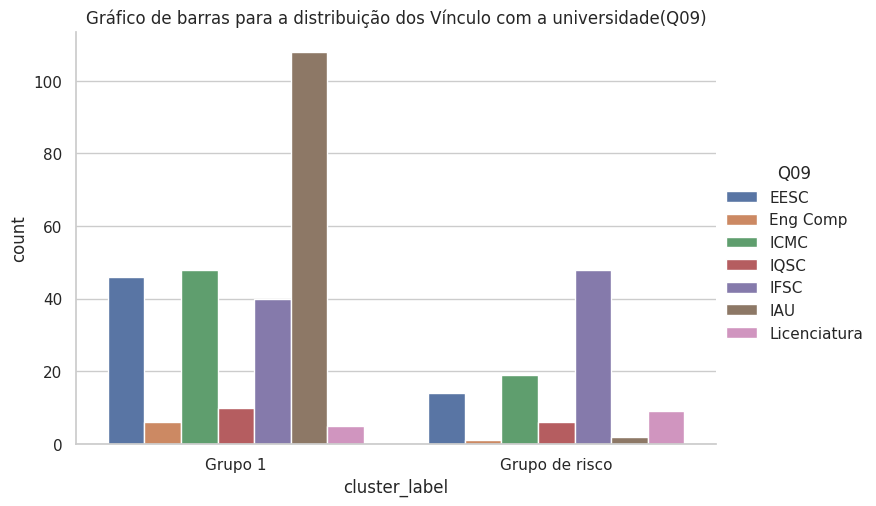

In [ ]:
sns.catplot(x='cluster_label', hue='Q09', data=X_cluster_other_metrics, kind='count', height=5, aspect=1.5)
plt.title('Gráfico de barras para a distribuição dos Vínculo com a universidade(Q09)')
plt.show()

In [ ]:
chi_square_test('Q09')

cluster_label  Grupo 1  Grupo de risco
Q09                                   
EESC            17.490          14.141
Eng Comp         2.281           1.010
IAU             41.065           2.020
ICMC            18.251          19.192
IFSC            15.209          48.485
IQSC             3.802           6.061
Licenciatura     1.901           9.091


 Estatística chi-quadrado 80.412 
 g.l : 6 
 p valor : 0.0 


IAU é pouco associado ao grupo de risco, enquanto IFSC é bastante associado ao grupo de risco

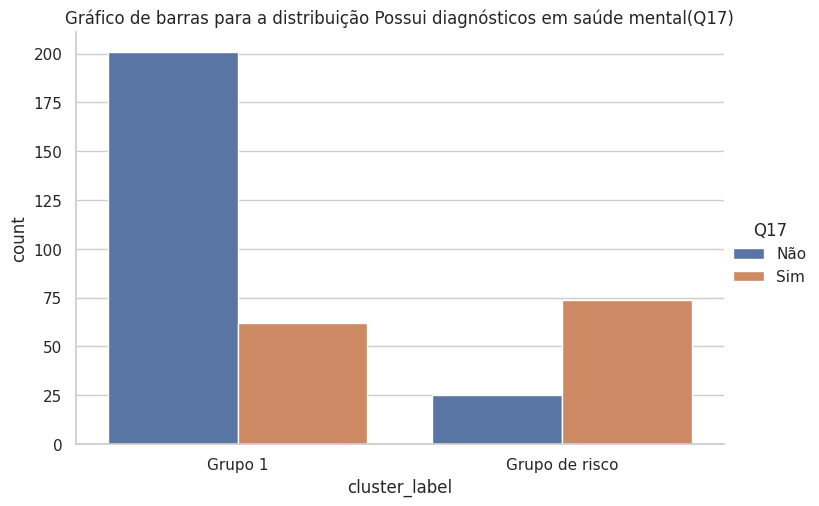

In [ ]:
sns.catplot(x='cluster_label', hue='Q17', data=X_cluster_other_metrics, kind='count', height=5, aspect=1.5)#, hue_order = ['2019 ou antes', '2020','2021','2022','2023'])
plt.title('Gráfico de barras para a distribuição Possui diagnósticos em saúde mental(Q17)')
plt.show()


In [ ]:
chi_square_test('Q17')

cluster_label  Grupo 1  Grupo de risco
Q17                                   
Não             76.426          25.253
Sim             23.574          74.747


 Estatística chi-quadrado 78.137 
 g.l : 1 
 p valor : 0.0 


A proporção de diagnóstico em saúde mental é maior para o grupo de risco

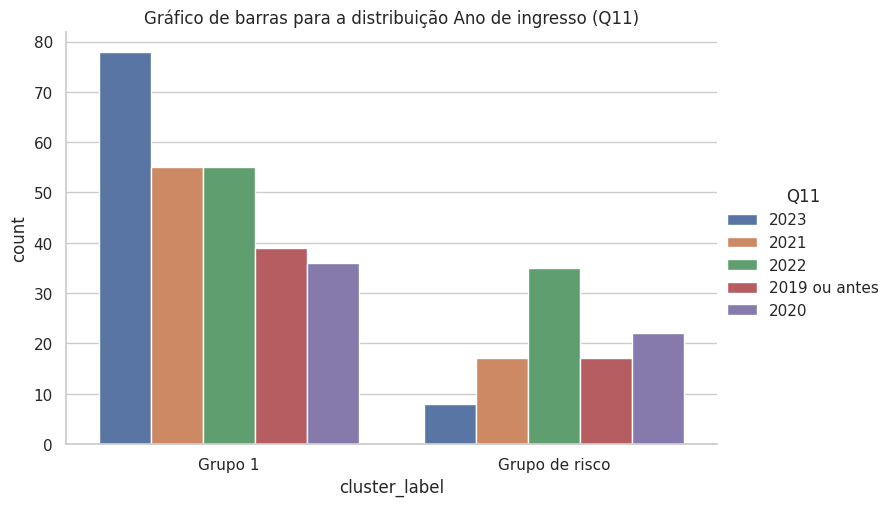

In [ ]:
sns.catplot(x='cluster_label', hue='Q11', data=X_cluster_other_metrics, kind='count', height=5, aspect=1.5)#, hue_order = ['2019 ou antes', '2020','2021','2022','2023'])
plt.title('Gráfico de barras para a distribuição Ano de ingresso (Q11)')
plt.show()


In [ ]:
chi_square_test('Q11')

cluster_label  Grupo 1  Grupo de risco
Q11                                   
2019 ou antes   14.829          17.172
2020            13.688          22.222
2021            20.913          17.172
2022            20.913          35.354
2023            29.658           8.081


 Estatística chi-quadrado 24.159 
 g.l : 4 
 p valor : 0.0 


Observa-se diferença entre os anos de ingresso. O ano de 2023 é associado ao grupo 1. Os alunos mais antigos (até 2020) são associados ao grupo de risco

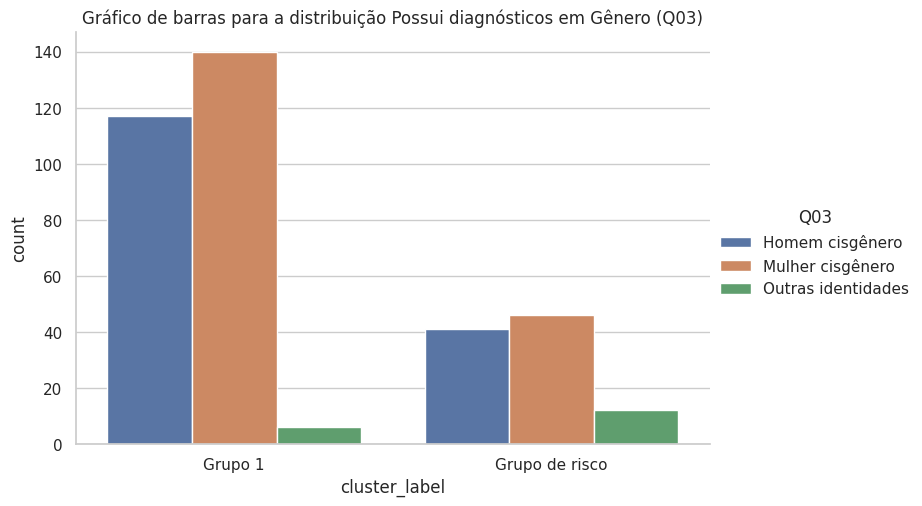

In [ ]:
sns.catplot(x='cluster_label', hue='Q03', data=X_cluster_other_metrics, kind='count', height=5, aspect=1.5)
plt.title('Gráfico de barras para a distribuição Possui diagnósticos em Gênero (Q03)')
plt.show()


In [ ]:
chi_square_test('Q03')

cluster_label       Grupo 1  Grupo de risco
Q03                                        
Homem cisgênero      44.487          41.414
Mulher cisgênero     53.232          46.465
Outras identidades    2.281          12.121


 Estatística chi-quadrado 14.802 
 g.l : 2 
 p valor : 0.001 


Notamos pelo gráfico e pela tabela de contingências (normalizada pela coluna) que há uma diferença na distribuição dos gêneros quando consideramos o grupo de risco identificado. Especificamente, na célula "Outras identidades", que é muito mais presente na coluna "grupo de risco". O teste chi-quadrado indica associação entre essas duas variávies

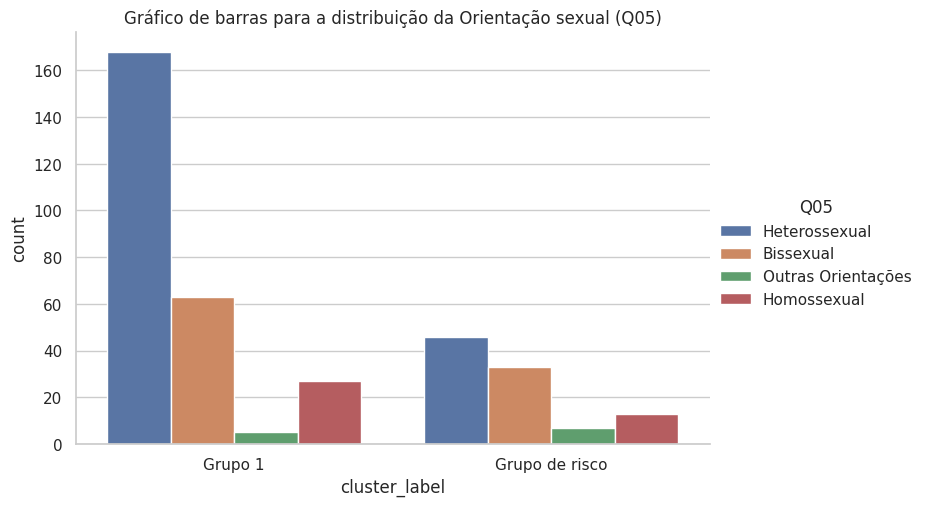

In [ ]:
sns.catplot(x='cluster_label', hue='Q05', data=X_cluster_other_metrics, kind='count', height=5, aspect=1.5)
plt.title('Gráfico de barras para a distribuição da Orientação sexual (Q05)')
plt.show()

In [ ]:
chi_square_test('Q05')

cluster_label       Grupo 1  Grupo de risco
Q05                                        
Bissexual            23.954          33.333
Heterossexual        63.878          46.465
Homossexual          10.266          13.131
Outras Orientações    1.901           7.071


 Estatística chi-quadrado 12.408 
 g.l : 3 
 p valor : 0.006 


Note que o grupo de risco tem uma maior presença de Homossexuais e outras Orientações Sexuais e Bissexuais, enquanto o grupo 1 tem uma maior presença de heterossexuais

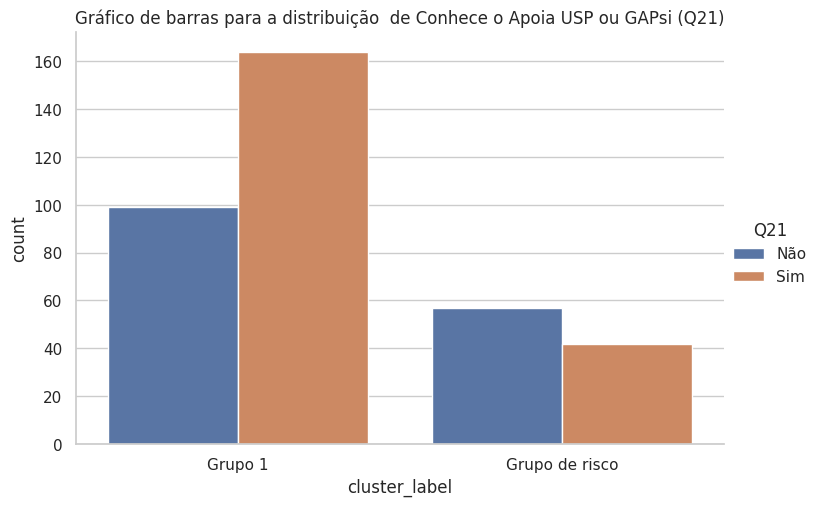

In [ ]:
sns.catplot(x='cluster_label', hue='Q21', data=X_cluster_other_metrics, kind='count', height=5, aspect=1.5)
plt.title('Gráfico de barras para a distribuição  de Conhece o Apoia USP ou GAPsi (Q21)')
plt.show()

In [ ]:
chi_square_test('Q21')

cluster_label  Grupo 1  Grupo de risco
Q21                                   
Não             37.643          57.576
Sim             62.357          42.424


 Estatística chi-quadrado 10.855 
 g.l : 1 
 p valor : 0.001 


Indivíduos que não conhecem Apoia USP ou GAPsi são associados ao grupo de risco

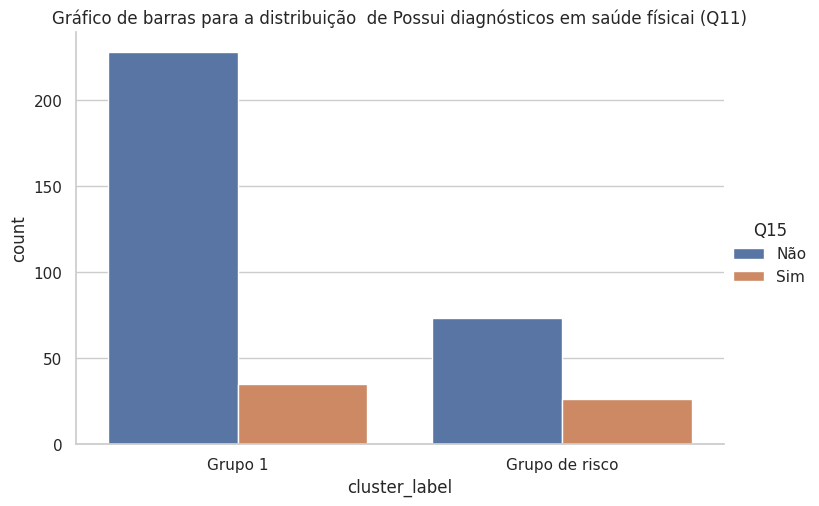

In [ ]:
sns.catplot(x='cluster_label', hue='Q15', data=X_cluster_other_metrics, kind='count', height=5, aspect=1.5)
plt.title('Gráfico de barras para a distribuição  de Possui diagnósticos em saúde físicai (Q11)')
plt.show()

In [ ]:
chi_square_test('Q15')

cluster_label  Grupo 1  Grupo de risco
Q15                                   
Não             86.692          73.737
Sim             13.308          26.263


 Estatística chi-quadrado 7.715 
 g.l : 1 
 p valor : 0.005 


Indivíduos que possuem diagnóstico em saúde física são associados ao grupo de risco

###### Quantitativa

Para variáveis quantitativas, foi realizada uma inspeção visual por meio de box plots, gráficos de densidade alisada e gráficos de distribuições acumuladas empíricas. Adicionalmente, quando é difícil concluir somente por meio da análise visual, um teste de Mann-Whitney U foi utilizado para verificar se a diferença nas médias é significativa.

Para o teste de  Mann-Whitney U considera-se a seguintes hipóteses

In [ ]:
X_cluster_other_metrics['Q06_escala_original'] = df['Q06']

In [ ]:
def get_plot_numerica(variavel):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12.5, 5))

    sns.boxplot(data=X_cluster_other_metrics, x="cluster_label", y=variavel, ax=ax1, hue = 'cluster_label')
    ax1.set_title("Violin Plot")

    sns.kdeplot(data=X_cluster_other_metrics, hue="cluster_label", x=variavel, fill=True, ax=ax2)
    ax2.set_title("KDE Plot")
    ax2.get_legend().remove()

    sns.ecdfplot(data=X_cluster_other_metrics, hue="cluster_label", x=variavel, ax=ax3)
    ax3.set_title("ECDF Plot")
    ax3.get_legend().remove()

    plt.tight_layout()
    # Essas  próximas linhas foram sugestão do gpt
    plt.subplots_adjust(top=0.85)
    fig.suptitle('Gráficos para a variável: ' + variavel, fontsize=16)

    plt.show()

In [ ]:
def resumo_continua(coluna):
  resumo =  X_cluster_other_metrics.loc[:, ['cluster_label', coluna]].groupby('cluster_label').agg(['mean', 'std', 'min',lambda x : x.quantile(0.25) , lambda x :  x.quantile(0.5) , lambda x : x.quantile(0.75)  ,'max', 'skew' , lambda x : x.kurtosis()])
  resumo.columns = ['mean', 'std', 'min', '25%', '50%', '75%', 'max', 'skewness', 'kurtosis(Fisher)']

  return resumo

In [ ]:
def get_WMW(coluna):
  p_val = WMW(X_cluster_other_metrics.loc[X_cluster_other_metrics['cluster_label'] == 'Grupo 1', coluna].to_numpy(),
              X_cluster_other_metrics.loc[X_cluster_other_metrics['cluster_label'] == 'Grupo de risco', coluna].to_numpy(),
              alternative='two-sided').pvalue
  return p_val

In [ ]:
def display_numerica(coluna):
  get_plot_numerica(coluna)
  display(resumo_continua(coluna).round(3))
  print(f"\n Valor p para teste de  Mann-Whitney U  {get_WMW(coluna)}")



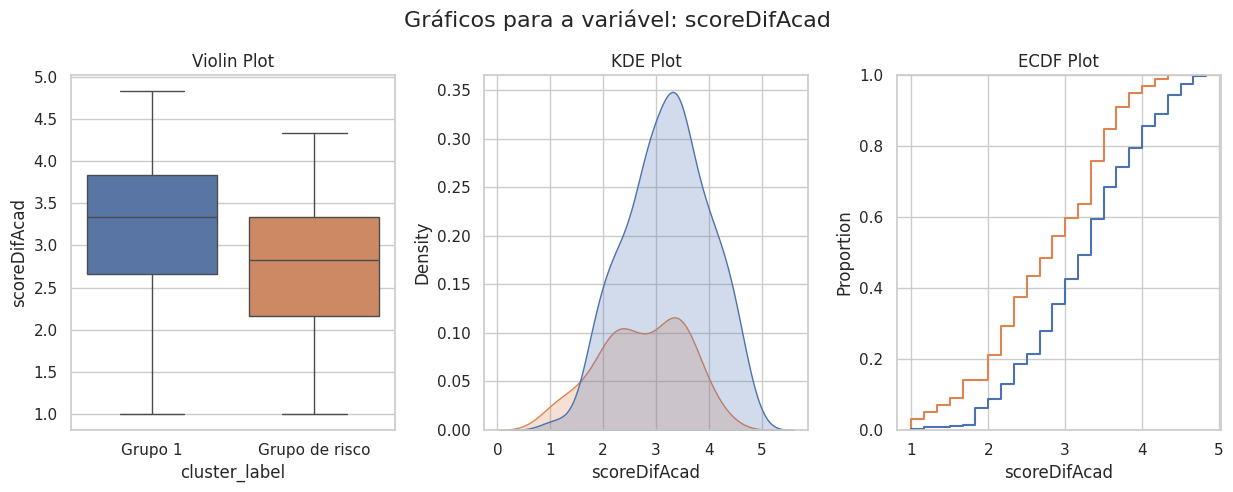

mean    std  min    25%    50%    75%    max  skewness  \
cluster_label                                                             
Grupo 1         3.209  0.778  1.0  2.667  3.333  3.833  4.833    -0.158   
Grupo de risco  2.746  0.816  1.0  2.167  2.833  3.333  4.333    -0.279   

                kurtosis(Fisher)  
cluster_label                     
Grupo 1                   -0.540  
Grupo de risco            -0.719


 Valor p para teste de  Mann-Whitney U  1.286775895108499e-05


In [ ]:
display_numerica('scoreDifAcad')

**ScoreDifAcad: score sobre dificuldade acadêmica (sentido positivo)**

Nesse caso,há evidências que a distribuição dos scores socbre dificuldade acadêmica do grupo 1  é maior do que a do grupo de risco


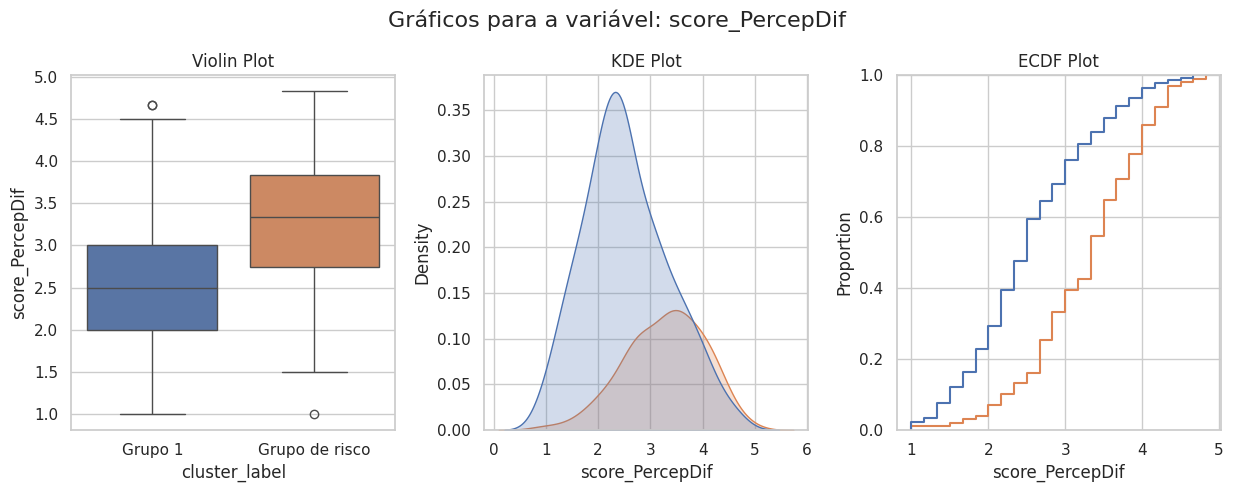

mean    std  min   25%    50%    75%    max  skewness  \
cluster_label                                                            
Grupo 1         2.535  0.806  1.0  2.00  2.500  3.000  4.667     0.379   
Grupo de risco  3.271  0.755  1.0  2.75  3.333  3.833  4.833    -0.417   

                kurtosis(Fisher)  
cluster_label                     
Grupo 1                   -0.328  
Grupo de risco            -0.065


 Valor p para teste de  Mann-Whitney U  1.3615806572376798e-13


In [ ]:
display_numerica('score_PercepDif')

**scorePercepDif: score sobre percepção de dificuldades (sentido negativo)**


Nesse caso,há evidências que a distribuição dos  score sobre percepção de dificuldades  de risco 1  é maior do que a do grupo 1


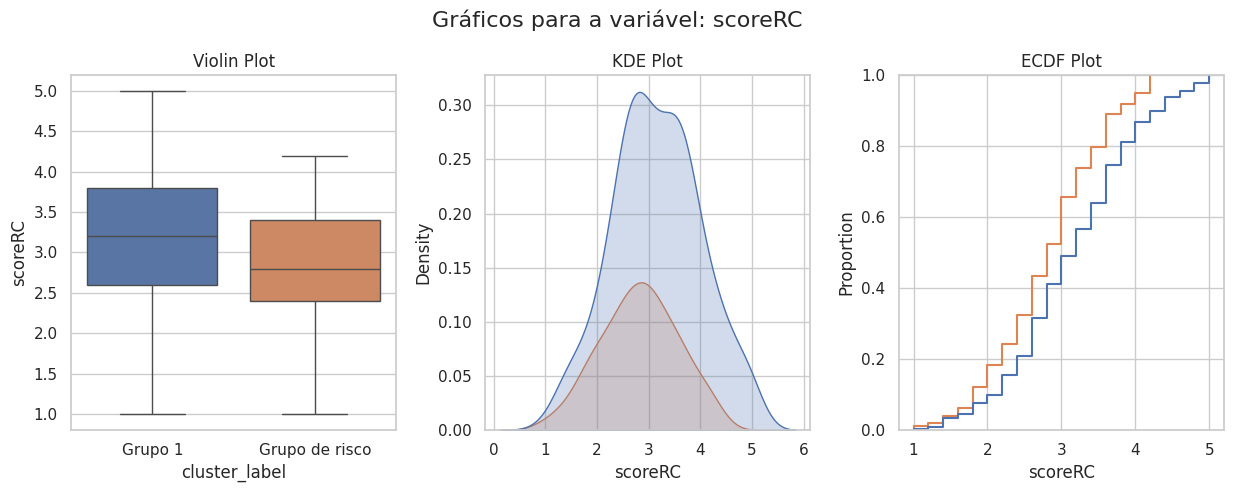

mean    std  min  25%  50%  75%  max  skewness  \
cluster_label                                                     
Grupo 1         3.151  0.850  1.0  2.6  3.2  3.8  5.0     0.028   
Grupo de risco  2.818  0.736  1.0  2.4  2.8  3.4  4.2    -0.113   

                kurtosis(Fisher)  
cluster_label                     
Grupo 1                   -0.365  
Grupo de risco            -0.449


 Valor p para teste de  Mann-Whitney U  0.0011824350220422473


In [ ]:
display_numerica('scoreRC')

**scoreRC: score sobre relações e comunicação na universidade (sentido positivo)**
Nesse caso, há evidências que  o score sobre relações/comunicações na universidade é menor para o grupo de risco

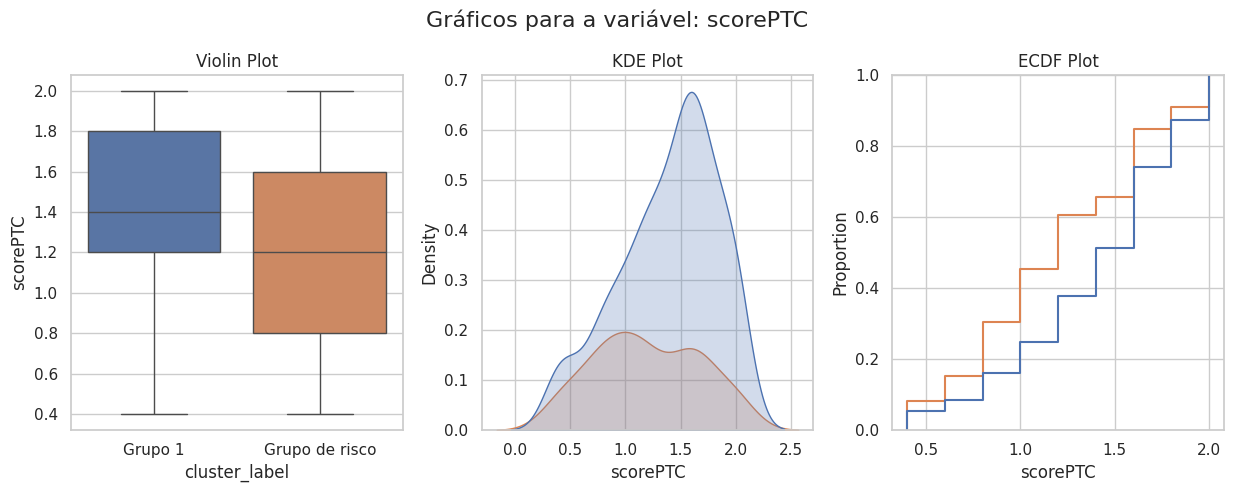

mean    std  min  25%  50%  75%  max  skewness  \
cluster_label                                                     
Grupo 1         1.390  0.442  0.4  1.2  1.4  1.8  2.0    -0.569   
Grupo de risco  1.198  0.472  0.4  0.8  1.2  1.6  2.0     0.060   

                kurtosis(Fisher)  
cluster_label                     
Grupo 1                   -0.455  
Grupo de risco            -0.999


 Valor p para teste de  Mann-Whitney U  0.00040115194406042405


In [ ]:
display_numerica('scorePTC')


**scorePTC: score sobre pertencimento na universidade (sentido positivo)**


Nesse caso, observa-se que o grupo de risco tem SCOREPTC menor do que o grupo de risco

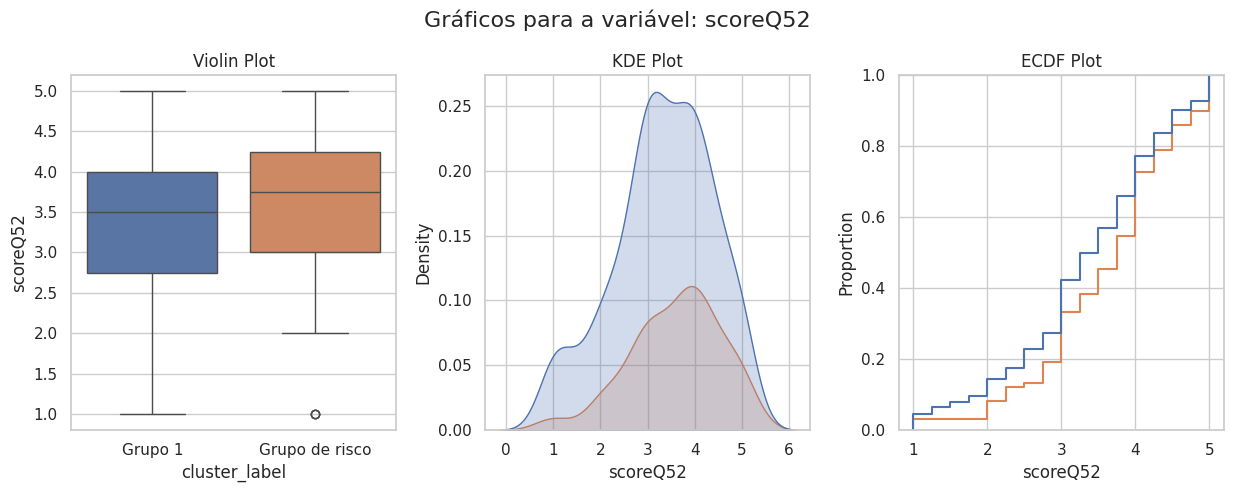

mean    std  min   25%   50%   75%  max  skewness  \
cluster_label                                                        
Grupo 1         3.327  1.040  1.0  2.75  3.50  4.00  5.0    -0.435   
Grupo de risco  3.591  0.947  1.0  3.00  3.75  4.25  5.0    -0.583   

                kurtosis(Fisher)  
cluster_label                     
Grupo 1                   -0.355  
Grupo de risco             0.141


 Valor p para teste de  Mann-Whitney U  0.03672467080710759


In [ ]:
display_numerica('scoreQ52')

**scoreQ52: score sobre discriminação na USP São Carlos (sentido negativo)**

Neste caso, o grupo de risco tem um score sobre a discriminação maior do que o grupo 1. No entanto, essa diferença não é tão evidente, e o valor de p é "marginalmente significativo" (muito próximo de 0.05).

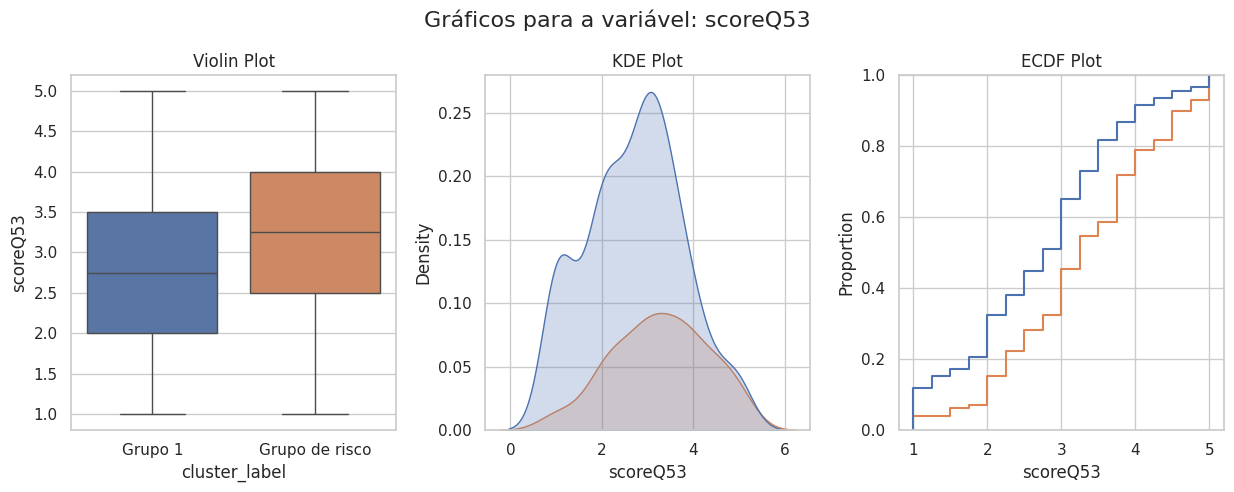

mean    std  min  25%   50%  75%  max  skewness  \
cluster_label                                                      
Grupo 1         2.714  1.056  1.0  2.0  2.75  3.5  5.0     0.074   
Grupo de risco  3.268  1.032  1.0  2.5  3.25  4.0  5.0    -0.191   

                kurtosis(Fisher)  
cluster_label                     
Grupo 1                   -0.601  
Grupo de risco            -0.583


 Valor p para teste de  Mann-Whitney U  1.9587463418900524e-05


In [ ]:
display_numerica('scoreQ53')

**scoreQ53: score sobre discriminação da unidade de ensino (sentido negativo)**

Nesse caso o  score sobre discriminação da unidade de ensino é maior para o grupo de risco



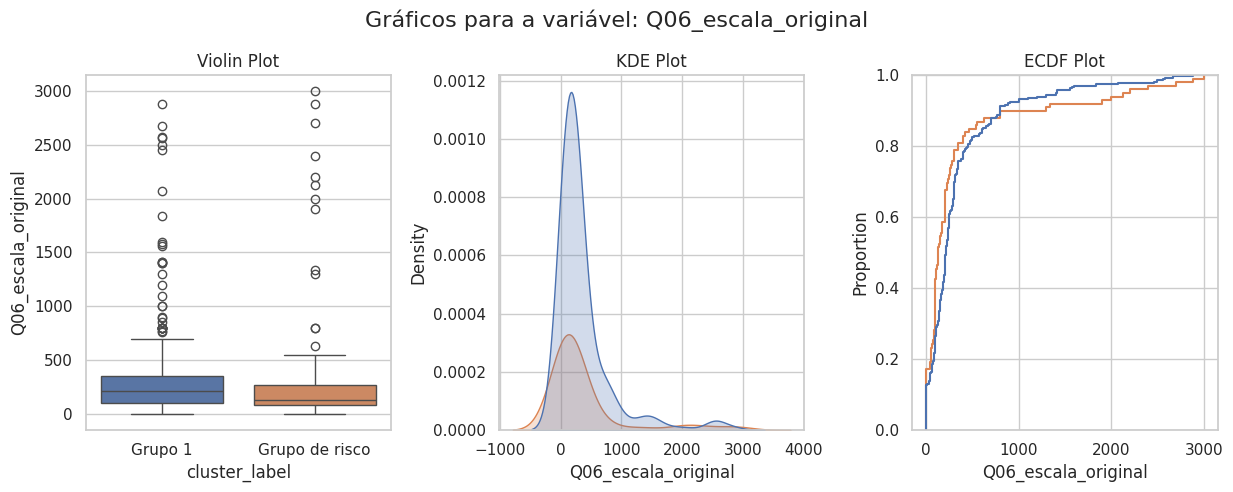

mean      std  min    25%    50%    75%     max  skewness  \
cluster_label                                                                  
Grupo 1         355.417  484.128  0.0  100.0  211.0  350.0  2879.0     3.015   
Grupo de risco  369.200  655.977  0.0   80.0  130.0  272.5  3000.0     2.758   

                kurtosis(Fisher)  
cluster_label                     
Grupo 1                   10.244  
Grupo de risco             6.851


 Valor p para teste de  Mann-Whitney U  0.014339298378535504


In [ ]:
display_numerica('Q06_escala_original')

In [ ]:
# Verifica a distribuição dos invíduos que moram em são carlos

X_cluster_other_metrics[X_cluster_other_metrics['Q06_escala_original'] == 0]['cluster_label'].value_counts(normalize = True).round(3)*100


cluster_label
Grupo 1           64.6
Grupo de risco    35.4
Name: proportion, dtype: float64

**Q06: Distância São Carlos- Endereço de procedência**
* Aqui devemos tomar cuidado com a interpretação do teste de Wilcoxon, já que a diferença aparentemente não é somente devido ao parâmetro de localização. Embora a mediana do grupo 1 seja maior do que a do grupo de risco, a dispersão (desvio padrão) é maior para o grupo de risco. O gráfico ECDF apresenta um padrão diferente dos demais observados neste trabalho, as curvas se cruzam em determinado ponto para distâncias menores (menores do que 1000, por exemplo). A CDF empírica do grupo 1 parece dominar a do grupo de risco, enquanto para valores maiores que 1000 essa relação se inverte
* 35.4%  dos invíduos que residem em são carlos pertencem ao grupo de risco

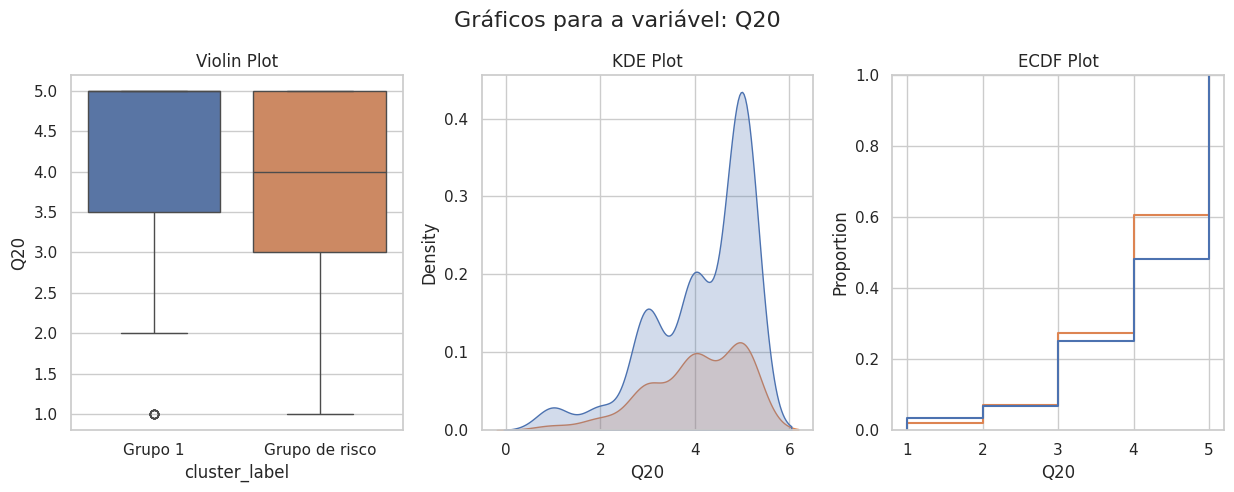

mean    std  min  25%  50%  75%  max  skewness  \
cluster_label                                                     
Grupo 1         4.163  1.059    1  3.5  5.0  5.0    5    -1.205   
Grupo de risco  4.030  0.994    1  3.0  4.0  5.0    5    -0.888   

                kurtosis(Fisher)  
cluster_label                     
Grupo 1                    0.853  
Grupo de risco             0.352


 Valor p para teste de  Mann-Whitney U  0.11148703249107221


In [ ]:
display_numerica('Q20')

● Q20: Possui as condições adequadas para minha permanência material na graduação

Nesse caso parce não haver muita diferença entre a distribuição da Q20 entre os clusters

### Conclusão

In [ ]:
X_cluster_other_metrics['cluster_label'].value_counts()

cluster_label
Grupo 1           263
Grupo de risco     99
Name: count, dtype: int64

Utilizamos a metodologia de análise de agrupamento hierárquico, por meio de clusters aglomerativos, para identificar um possível grupo de risco que contém 99 indivíduos. O coeficiente de Cramér V foi utilizado para quantificar a associação entre o nível SQR (Nível de Transtornos Mentais) e a divisão de clusters. Em seguida, interpretamos os indivíduos que pertencem a esse grupo, que no total somam 99 entre os 392 indivíduos. A seguinte tabela resume as características desse grupo de risco. Nela, o grupo 1 refere-se ao outro grupo identificado pelos clusters. Por simplicidade, optamos por não nomear esse grupo.  (**) indicarelação suspeita



In [ ]:
tabela_cluster = dicionario.copy()

In [ ]:
tabela_cluster.drop(['Tipo do atributo', 'Questão', 'Valores'],axis = 1, inplace= True)

In [ ]:
tabela_cluster = tabela_cluster.drop([16,17], axis = 0)

In [ ]:
obs= [
    'Não é observada diferença significativa',
    'O gênero "Outras identidades" é associado ao grupo de risco',
    'Não é observada diferença significativa',
    'Homossexuais, outras orientações sexuais e bissexuais são associados ao grupo de risco',
    'A distribuição das distâncias entre os grupos é semelhante. O grupo de risco contém menos indivíduos que residem em São Carlos',
    'Não é observada diferença significativa',
    'Observa-se diferença entre os institutos, em especial IFSC (associado ao grupo de risco) e IAU (associado ao grupo 1)',
    'Observa-se diferença entre os cursos, principalmente Arquitetura e Urbanismo (associado ao grupo 1) e Física Computacional (associado ao grupo de risco)',
    'Observa-se diferença entre os anos de ingresso. O ano de 2023 é associado ao grupo 1. Os alunos mais antigos (até 2020) são associados ao grupo de risco',
    'Não é observada diferença significativa',
    'Indivíduos que possuem diagnóstico em saúde física são associados ao grupo de risco',
    'Indivíduos que possuem diagnóstico em saúde mental são associados ao grupo de risco',
    'Não é observada diferença significativa',
    'Não é observada diferença significativa',
    'Indivíduos que não conhecem Apoia USP ou GAPsi são associados ao grupo de risco',
    'Indivíduos com score de percepção de dificuldade acadêmica alto  foram associados ao grupo de risco',
    'Indivíduos com score de dificuldade acadêmica alto não foram associados ao grupo de risco (**)',
    'Indivíduos que se comunicam menos com a universidade são relacionados ao grupo de risco',
    'Indivíduos com menor score de pertencimento são associados ao grupo de risco',
    'Indivíduos com maior score de discriminação na USP São Carlos são associados ao grupo de risco',
    'Indivíduos com maior score de discriminação na USP São Carlos são associados ao grupo de risco'
]



In [ ]:
tabela_cluster['Obserações'] = obs

In [ ]:
pd.set_option('display.max_colwidth', None)

display(tabela_cluster)

Conteúdo  \
0                                                                                                                                   Idade   
1                                                                                                                                  Gênero   
2                                                                                                                              Raça/Etnia   
3                                                                                                                       Orientação sexual   
4                                                                                           Distância São Carlos- Endereço de procedência   
5                                                                                                    Mora ou não no alojamento estudantil   
6                                                                                                              Vínculo com a universidade   
7                                                                                                                      Curso de Graduação   
8                                                                                                                         Ano de ingresso   
9                                                                                              Exerce atividade remunerada além do estudo   
10                                                                                                    Possui diagnósticos em saúde física   
11                                                                                                    Possui diagnósticos em saúde mental   
12                                                                                                     Recebe auxílio permanência (PAPFE)   
13   Possui as condições adequadas para minha permanência material na graduação (moradia, alimentação, transporte, custos materiais, etc)   
14                                                                                                           Conhece o Apoia USP ou GAPsi   
15                                                                               score sobre percepção de dificuldades (sentido negativo)   
18                                                                                   score sobre dificuldade acadêmica (sentido positivo)   
19                                                                  score sobre relações e comunicação na universidade (sentido positivo)   
20                                                                           score sobre pertencimento na universidade (sentido positivo)   
21                                                                         score sobre discriminação da USP São Carlos (sentido negativo)   
22                                                                      score sobre discriminação da unidade de ensino (sentido negativo)   

                                                                                                                                                  Obserações  
0                                                                                                                    Não é observada diferença significativa  
1                                                                                                O gênero "Outras identidades" é associado ao grupo de risco  
2                                                                                                                    Não é observada diferença significativa  
3                                                                     Homossexuais, outras orientações sexuais e bissexuais são associados ao grupo de risco  
4                             A distribuição das distâncias entre os grupos é semelhante. O grupo de risco contém menos indivíduos que residem em São Carlos  
5                                                                       

In [ ]:
(tabela_cluster[tabela_cluster['Obserações'] != 'Não é observada diferença significativa'])

Conteúdo  \
1                                                                   Gênero   
3                                                        Orientação sexual   
4                            Distância São Carlos- Endereço de procedência   
6                                               Vínculo com a universidade   
7                                                       Curso de Graduação   
8                                                          Ano de ingresso   
10                                     Possui diagnósticos em saúde física   
11                                     Possui diagnósticos em saúde mental   
14                                            Conhece o Apoia USP ou GAPsi   
15                score sobre percepção de dificuldades (sentido negativo)   
18                    score sobre dificuldade acadêmica (sentido positivo)   
19   score sobre relações e comunicação na universidade (sentido positivo)   
20            score sobre pertencimento na universidade (sentido positivo)   
21          score sobre discriminação da USP São Carlos (sentido negativo)   
22       score sobre discriminação da unidade de ensino (sentido negativo)   

                                                                                                                                                  Obserações  
1                                                                                                O gênero "Outras identidades" é associado ao grupo de risco  
3                                                                     Homossexuais, outras orientações sexuais e bissexuais são associados ao grupo de risco  
4                             A distribuição das distâncias entre os grupos é semelhante. O grupo de risco contém menos indivíduos que residem em São Carlos  
6                                      Observa-se diferença entre os institutos, em especial IFSC (associado ao grupo de risco) e IAU (associado ao grupo 1)  
7   Observa-se diferença entre os cursos, principalmente Arquitetura e Urbanismo (associado ao grupo 1) e Física Computacional (associado ao grupo de risco)  
8   Observa-se diferença entre os anos de ingresso. O ano de 2023 é associado ao grupo 1. Os alunos mais antigos (até 2020) são associados ao grupo de risco  
10                                                                       Indivíduos que possuem diagnóstico em saúde física são associados ao grupo de risco  
11                                                                       Indivíduos que possuem diagnóstico em saúde mental são associados ao grupo de risco  
14                                                                           Indivíduos que não conhecem Apoia USP ou GAPsi são associados ao grupo de risco  
15                                                       Indivíduos com score de percepção de dificuldade acadêmica alto  foram associados ao grupo de risco  
18                                                            Indivíduos com score de dificuldade acadêmica alto não foram associados ao grupo de risco (**)  
19                                                                   Indivíduos que se comunicam menos com a universidade são relacionados ao grupo de risco  
20                                                                              Indivíduos com menor score de pertencimento são associados ao grupo de risco  
21                                                            Indivíduos com maior score de discriminação na USP São Carlos são associados ao grupo de risco  
22                                                            Indivíduos com maior score de discriminação na USP São Carlos são associados ao grupo de risco

## PARTE 2

### Redução de dimensionalidade

#### PCA

Outro método aplicado, foi o mais tradicional, o PCA, separando as variáveis numéricas (incluindo as de escala com resposta de 1 a 5). Note que usando os parâmetros rescale_with_mean e rescale_with_std como True, o pacote já se encarrega de lidar com a padronização dos dados.

In [ ]:
X_pca = df[['Q06', 'Q20', 'score_PercepDif', 'scoreDifAcad', 'scoreRC', 'scorePTC', 'scoreQ52', 'scoreQ53']]

In [ ]:
pca = prince.PCA(
    n_components=5,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
pca = pca.fit(X_pca)

In [ ]:
pca.eigenvalues_summary

eigenvalue % of variance % of variance (cumulative)
component                                                    
0              2.778        34.73%                     34.73%
1              1.417        17.71%                     52.43%
2              1.013        12.67%                     65.10%
3              0.810        10.13%                     75.23%
4              0.692         8.64%                     83.88%

Nas 5 primeiras componentes, mais de 80% da variância total dos dados provenientes das variáveis quantitativa (8) está sendo explicada.

Text(0.5, 0, 'Componente')

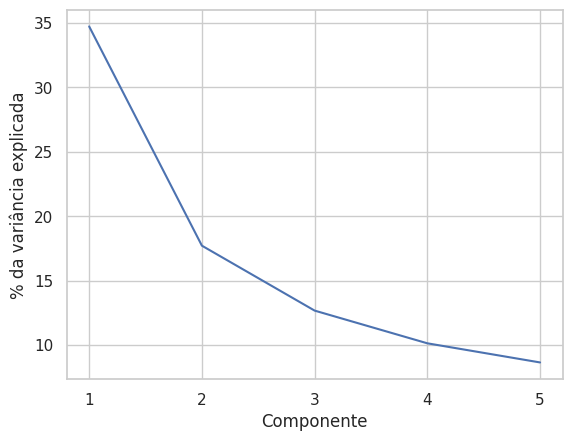

In [ ]:
plt.plot([1, 2, 3, 4, 5], pca.percentage_of_variance_)
plt.xticks(range(1, 6))
plt.ylabel('% da variância explicada')
plt.xlabel('Componente')

Considerando o gráfico de cotovelo, a terceira componente seria um bom ponto de corte.

In [ ]:
pca_corte = prince.PCA(
    n_components=3,
    rescale_with_mean=True,
    rescale_with_std=True,
    copy=True,
    check_input=True,
    engine='sklearn',
    random_state=42
)
pca_corte = pca_corte.fit(X_pca)

In [ ]:
# Contribuição de cada coluna para componentes
pca_corte.column_contributions_.style.format('{:.0%}')

<Axes: xlabel='component', ylabel='variable'>

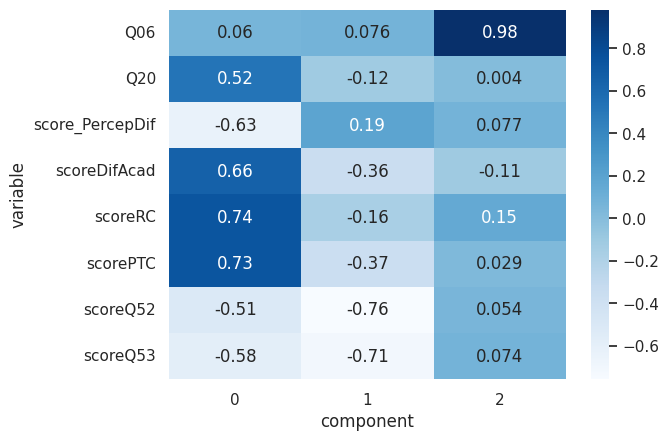

In [ ]:
# Correlação das colunas com as componentes princpais
sns.heatmap(pca_corte.column_correlations, cmap  = 'Blues',annot=True)

Aqui estão as correções:

* Primeira componente principal:
  * Correlação positiva: Score sobre relações e comunicação na universidade (sentido positivo), score sobre pertencimento na universidade (sentido positivo), score sobre dificuldade acadêmica (sentido positivo), Q20 (Possui as condições adequadas para minha permanência material na graduação).
  * Correlação negativa: Score sobre discriminação da USP São Carlos (sentido negativo), score sobre discriminação da unidade de ensino (sentido negativo), score sobre percepção de dificuldades (sentido negativo).

  Pode ser interpretada como indicativa de indivíduos que possuem uma boa relação com a universidade. A correlação positiva está relacionada a variáveis associadas a uma "boa relação com a universidade", medidas de forma positiva. Ou seja, quanto maiores esses scores, melhor é a relação com a universidade. Já as correlações negativas estão relacionadas a variáveis associadas à relação com a universidade, mas de forma negativa; isso é : quanto menores esses scores, melhor é a relação com a universidade. Ou seja, as correlações dessa componente principal indicam que ela pode estar relacionada com o "bom relacionado com a universidade"

* Segunda componente principal:
  * Correlação negativa: Score sobre discriminação da USP São Carlos (sentido negativo), score sobre discriminação da unidade de ensino (sentido negativo), score sobre percepção de dificuldades (sentido negativo).

  Esta componente é similar à primeira componente principal, porém atribui-se mais peso aos scores das questões Q52 e Q53. Algumas variáveis que tinham correlação positiva, considerando a primeira componente principal, apresentaram correlação negativa na segunda componente, mas essa correlação não é alta.

* Terceira componente principal:
  * Correlação positiva: Q06 - Distância São Carlos-Endereço de procedência.

  Aqui a correlação é positiva e forte com a distância entre São Carlos e o endereço de procedência. Pode ser interpretada como uma componente que considera muito o peso da distância entre São Carlos e o endereço de procedência.